# Galactic SED Fitting Testing

### Ben Hanson 

## Importing Modules

In [1]:
import h5py
import import_ipynb
import os
os.environ['SPS_HOME'] = '/home/benjamin.hanson/UF REU/SED-Fitting/UF-REU-PROJECT'
import fsps
%matplotlib inline
import math
import matplotlib.pyplot as plt
import csv
import numpy as np
import scipy.odr.odrpack as odrpack
import math
import scipy as scipy
from scipy import optimize
from scipy import interp
from scipy import integrate
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import norm
import sys
import csv
from importlib import reload
from rbvfit import model as m
reload(m)

import emcee
import corner
import scipy.optimize as op

width = 30

import time
from multiprocessing import cpu_count
from multiprocessing import Pool
import random
from IPython.display import clear_output

## Importing Functions

In [2]:
def creating_array(metallicity_array, age_array):
    
    mass_array = []
    
    print("Deleting previous iterations of spectrums...")
    # Deleting previous iteration of spectrum
    if 'sp' in locals():
        del sp
    
    rows = len(metallicity_array)
    columns = len(age_array)
    with open('stellar_bank_{}x{}.csv'.format(str(int(rows)), str(int(columns))), 'w') as f:
        write = csv.writer(f)
        print("Creating new array...")
        # Creating Array
        
        sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, sfh=0, logzsol = 0, dust_type=2, dust2=0.0)
       
        for i in range(len(metallicity_array)):
            
            metallicity = metallicity_array[i]
            sp.params['logzsol'] = metallicity
                        
            for j in range(len(age_array)):
                
                age = age_array[j]
                wave, spec = sp.get_spectrum(tage = age)
                mass_array.append(str(sp.stellar_mass))
                spec = list(spec)
                spec = list(map(str, spec))
                write.writerow(spec)   
    
    print("Spectrum array complete. Writing Mass Array.")
    with open('stellar_bank_{}x{}_mass.csv'.format(str(int(rows)), str(int(columns))), 'w') as f:
        write = csv.writer(f)
        
        for i in range(len(mass_array)):
            
            value = mass_array[i]
            write.writerow([value])
            
    print("Mass Array Complete")    
        
def reading_csv(file_name, rows, columns):
    
    print("Reading array...")
    new_array = []
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            new_array.append(row)
    
    print("Unflattening array...")
    # Unflattening Array
    uf_array = []
    uf_sub_array = []

    r = rows
    c = columns
    iterator = 0

    for i in range(r):
        for j in range(c):
            new_array[iterator] = list(map(float, new_array[iterator]))
            uf_sub_array.append(new_array[iterator])
            iterator += 1
        uf_array.append(uf_sub_array)
        uf_sub_array = []
    
    return uf_array

def reading_csv_obs(file_name, rows, columns, fields, layers):
    
    print("Reading array...")
    new_array = []
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            new_array.append(row)
    
    print("Unflattening array...")
    # Unflattening Array
    uf_array = []
    uf_sub_array = []
    uf_sub_sub_array = []
    uf_sub_sub_sub_array = []

    r = rows
    c = columns
    f = fields
    l = layers
    iterator = 0

    for i in range(r):
        for j in range(c):
            for k in range(f):
                for m in range(l):
                    new_array[iterator] = list(map(float, new_array[iterator]))
                    uf_sub_sub_sub_array.append(new_array[iterator])
                    iterator += 1
                uf_sub_sub_array.append(uf_sub_sub_sub_array)
                uf_sub_sub_sub_array = []
            uf_sub_array.append(uf_sub_sub_array)
            uf_sub_sub_array = []
        uf_array.append(uf_sub_array)
        uf_sub_array = []        
    
    return uf_array

def make_spectrum(age, metallicity):
    sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, sfh=0, logzsol= metallicity, dust_type=2, dust2=0.0)
    wave, spec = sp.get_spectrum(tage = age)
    del sp
    
    return wave, spec
    
def chi_sq_func(obs_Spec, exp_Spec):
    chiSq = 0
    for i in range(len(obs_Spec)):
        chiSq += ((obs_Spec[i] - exp_Spec[i])**2)/exp_Spec[i]
        
    return chiSq

def plt_spectra(wave, spec, theta):
    plt.loglog(wave, spec, label = "Params: logZ = {}, Age (Gyr) = {}".format(theta[0], theta[1]))

def model_guess(beta,input_wave):
    
    spec = interpolating_spec(beta)[0]
    
    if (len(spec) != len(input_wave)):
        trunc_spec = np.interp(input_wave, wave, spec)
        spec = trunc_spec    

    return spec

def model_guess_obs(beta,input_wave):
    
    spec = obs_interpolating_spec(beta)[0]
    
    if (len(spec) != len(input_wave)):
        trunc_spec = np.interp(input_wave, wave, spec)
        spec = trunc_spec    

    return spec
    
def make_corner_plots(sampler):
          
    samples=sampler.chain[:, 100:, :].reshape((-1, ndim))#sampler.flatchain
    st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
    figure=corner.corner(samples, labels=text_label, truths=st)
    theta_prime=st

    value1 =np.percentile(samples,32,axis=0)
    value2 = np.percentile(samples,68,axis=0)    
    axes = np.array(figure.axes).reshape((ndim, ndim))

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(value1[i], color="aqua")
        ax.axvline(value2[i], color="aqua")

    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(value1[xi],color="aqua")
            ax.axvline(value2[xi],color="aqua")
            #ax.axhline(value1[yi], color="g")
            #ax.axhline(value2[yi], color="r")
            #ax.plot(value1[xi], value1[yi], "sg")
            #ax.plot(value2[xi], value2[yi], "sr")

def build_weight_array(weight_array, row_array, column_array, weight_added_array):
    for i in range(len(row_array)):
        weight_array[row_array[i]][column_array[i]] += weight_added_array[i]
    return weight_array    

def generate_random_weight_array(lb, ub, metallicity_array, age_array):
    
    weight_array= []
    
    s2 = np.random.normal(1.0, 0.01, 10000)
    count2, bins2, ignored2 = plt.hist(s2, 3, stacked = True, density = True)

    count2 *= 1 / count2[1]
    
    for i in range(len(metallicity_array)):
        bounds = np.array([lb, ub])
        mean = np.mean(bounds)
        std = mean * 0.1
        s = np.random.normal(mean, std, 10000)
        count, bins, ignored = plt.hist(s, 10, stacked = True, density = True)
        
        correction = 1 / sum(count)
        count *= correction 
        count *= count2[i] * ub
    
        count[count > ub] = ub
        count[count < lb] = lb
        weight_array.append(list(count))
    
    return weight_array
                      
def galactic_spec(weight_array):
    
    row_array, column_array = convert_weight_array(weight_array, metallicity_space, age_space)
    met_array, age_array = convert_arrays(row_array, column_array, metallicity_space, age_space)
    weight_array = weight_array.flatten()

    total_spec = np.zeros(5994)

    for i in range(len(met_array)):
        met = np.array([met_array[i]])
        age = np.array([age_array[i]])

        theta = np.concatenate((met, age))
        spec = interpolating_spec(theta)[0]
        total_spec += (spec * weight_array[i])
    
    return total_spec

def galactic_model_guess(weight_array, input_wave):
    
    total_spec = galactic_spec(weight_array)
    
    if (len(total_spec) != len(input_wave)):
        trunc_spec = np.interp(input_wave, wave, total_spec)
        total_spec = trunc_spec        
    
    return total_spec

def print_and_plot_results(sampler, wave, spec, title, galaxy, model):
    
    samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
    st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
    theta_prime=st[:]
    
    print("Derived values are (weight array): \n {}".format(theta_prime))   
    best_fit = model(theta_prime, wave)

    fig= plt.figure(figsize=(12,8))
    
    plt.loglog(wave, spec, ls = 'dotted', label= galaxy) 
    plt.title(title, fontsize = 20)
    plt.ylabel('Intensity (Solar luminosity/Hz)', fontsize = 18) # Labeling the x-axis
    plt.xlabel('Wavelength (Angstroms)', fontsize = 18) # Labeling the y-axis
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})
    
    return best_fit, theta_prime

def convert_arrays(row_array, column_array, metallicity_space, age_space):
    
    met_array = []
    age_array = []
    
    for i in range(len(row_array)):
        met_array.append(metallicity_space[row_array[i]])
        age_array.append(round(age_space[column_array[i]], 4))
        
    return met_array, age_array

def convert_weight_array(weight_array, metallicity_space, age_space):
    
    row_array = []
    column_array = []
    weight_array = np.reshape(weight_array, (len(metallicity_space), len(age_space)))
    
    for i in range(len(weight_array)):
        for j in range(len(weight_array[0])):
            if (weight_array[i][j] != 0):
                row_array.append(i)
                column_array.append(j)
                
    return row_array, column_array

def initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, snorm, enorm, input_wave, model):
    
    likelihood = []
    fits = []
    weight_arrays = []
    total_steps = 0
    curr_likelihood = 0
    convergence_status = False
    
    if (convergence_check == False):
        
        while (total_steps < break_steps):
            for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps, skip_initial_state_check = True)):
                n = int((width+1) * float(i) / no_of_steps)
                sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
            sys.stdout.write("\n")
            clear_output(wait=True)
            samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
            st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
            curr_likelihood = lnlike(st, model, input_wave, snorm, enorm)
            likelihood.append(curr_likelihood)
            sampler_ = np.array( sampler.chain )
            sub_array = []
            position_array = []
            chain_length = len(sampler_[0])
            for i in range(len(sampler_)):
                for j in range(len(sampler_[0][0])):           
                    sub_array.append(sampler_[i][chain_length-1][j])
                position_array.append(sub_array)
                sub_array = []
    
            pos = np.array(position_array)
            total_steps += no_of_steps
            print("Steps Taken: ", total_steps, "Likelihood: ", curr_likelihood)
    else:
        while(convergence_status == False):
            for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps, skip_initial_state_check = True)):
                n = int((width+1) * float(i) / no_of_steps)
                sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
            sys.stdout.write("\n")
            clear_output(wait=True)
            samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
            st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
            curr_likelihood = lnlike(st, model, input_wave, snorm, enorm)
            likelihood.append(curr_likelihood)
            sampler_ = np.array( sampler.chain )
            convergence_status, pos = check_convergence(sampler_, convergence_accuracy)
            total_steps += no_of_steps
            print("Steps Taken: ", total_steps, "Likelihood: ", curr_likelihood)
            if (total_steps >= break_steps):
                convergence_status = True
                print("Convergence not found before break.")

        print("Total steps to converge: ", total_steps)

    return sampler, likelihood

def check_convergence(sampler_, convergence_accuracy):
    
    # Converting Sampler Array to something more useable
    chain = []
    walkers = []
    parameters = []
    
    chain_length = len(sampler_[0])

    for i in range(len(sampler_[0][0])):
        for j in range(len(sampler_)):
            for k in range(len(sampler_[0])):
                chain.append(sampler_[j][k][i])
            walkers.append(chain)
            chain = []
        parameters.append(walkers)
        walkers = []  
            
    # Getting Last Position to save 
    sub_array = []
    position_array = []

    for i in range(len(sampler_)):
        for j in range(len(sampler_[0][0])):           
            sub_array.append(sampler_[i][chain_length-1][j])
        position_array.append(sub_array)
        sub_array = []
    
    position = np.array(position_array)
    
    # Checking Convergence of Walkers
    
    walkers = len(parameters[0])
    chain_length = len(parameters[0][0])
    convergence_status = True
    avg_serr = 0
    
    for i in range(len(parameters)):
        for j in range(len(parameters[0])):
            serr = np.std(parameters[i][j])/(chain_length)
            avg_serr += serr
        avg_serr /= walkers
        
        if (avg_serr <= convergence_accuracy):
            continue
        else:
            print("Parameter {} has not converged. Avg. SE was {:.3e}.".format(i, avg_serr))
            convergence_status = False
            break
            
    return convergence_status, position


######## Computing Likelihoods######
def lnprior(theta, lb, ub):
    for index in range(0, len(lb)):
        if (lb[index] > theta[index]) or (ub[index] < theta[index]):
            return -np.inf
    return 0.0

def lnlike(theta, model, x, y, yerr):
    model_y = model(theta, x)
    #model_y = np.log10(setting_min(model_y))
    #y = np.log10(setting_min(y))
    #yerr = np.log10(setting_min(yerr))
    inv_sigma2 = 1.0/(yerr**2)
    all_c2_values = (y - model_y) ** 2 * inv_sigma2  - np.log10(inv_sigma2)
    return -0.5 * (np.sum( all_c2_values  )) 

def lnprob(theta, lb, ub, model, x, y, yerr):
    lp = lnprior(theta, lb, ub)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, model, x, y, yerr)

def optimize_guess(model, theta, lb, ub, x, y, yerr):
    nll = lambda *args: -lnprob(*args)
    result = op.minimize(nll, [theta], args=(lb, ub, model, x, y, yerr))
    p = result["x"]
    return p

def galsedatlas_read_spectral_data(filename):
    rest_wave = []
    flux = []
    obs_wave = []
    source = []
    iterator = 0
    with open(filename, 'r') as f:
        for line in f:
            if (line[0] != '#'):
                line = line.split()
                for item in line:
                    if((item != " ") or (item != "\n")):
                        if (iterator % 4 == 0):
                            rest_wave.append(float(item))
                        elif (iterator % 4 == 1):
                            flux.append(float(item))
                        elif (iterator % 4 == 2):
                            obs_wave.append(float(item))
                        else:
                            source.append(float(item))

                        iterator += 1

    rest_wave = np.array(rest_wave)
    flux = np.array(flux)
    flux *= (rest_wave ** 2)
    obs_wave = np.array(obs_wave)
    source = np.array(source)
    return np.array(rest_wave), np.array(flux), np.array(obs_wave), np.array(source)

def add_to_bank(filename, description, array):
    array = list(array)
    array.insert(0, description)
    
    with open(filename, 'a') as f:
        write = csv.writer(f)
        write.writerow(array)
        
def read_through_bank(filename, description):
    try_again = True
    array = []
    while try_again == True:
        with open(filename) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                if row[0] == description:
                    array = row
                    try_again = False
        if (try_again == True):
            print("Description not found. Input new description")
            description = str(input())
        if (description == "Exit"):
            print("Exiting")
            return array
        
    array.pop(0)
    array = [float(i) for i in array]
    return array

def mass_to_light_calc(input_weight_array, input_spec, input_wave):
    
    mass_light_ratio = 0
    total_luminosity = 0
    
    c = 3E18
    frequency = c / input_wave
    frequency = np.flip(frequency)
    input_spec = np.flip(input_spec)

    total_luminosity = np.trapz(input_spec,frequency)              
    
    row_array, column_array = convert_weight_array(input_weight_array, metallicity_space, age_space)
    met_array, age_array = convert_arrays(row_array, column_array, metallicity_space, age_space)
    input_weight_array = input_weight_array.flatten()

    total_mass = 0

    for i in range(len(met_array)):
        met = np.array([met_array[i]])
        age = np.array([age_array[i]])

        theta = np.concatenate((met, age))
        mass = interpolating_mass(theta)[0][0]
        total_mass += (input_weight_array[i] * mass)
        
    mass_light_ratio = total_mass / total_luminosity
    
    return mass_light_ratio

def total_luminosity_calc(input_spec, input_wave):
    
    total_luminosity = 0
    
    c = 3E18
    frequency = c / input_wave
    frequency = np.flip(frequency)
    input_spec = np.flip(input_spec)

    total_luminosity = np.trapz(input_spec,frequency)              
    
    return total_luminosity

def get_uncertainty(sampler):
    
    sampler_ = np.array( sampler.chain )
    sub_array = []
    position_array = []
    chain_length = len(sampler_[0])
    for i in range(len(sampler_)):
        for j in range(len(sampler_[0][0])):           
            sub_array.append(sampler_[i][chain_length-1][j])
        position_array.append(sub_array)
        sub_array = []

    position_array = np.array(position_array)

    distributions = []
    sub_array = []
    
    for i in range(len(position_array[0])):
        for j in range(len(position_array)):
            sub_array.append(position_array[j][i])

        distributions.append(sub_array)
        sub_array = []

    distributions = np.array(distributions)
    
    unc = []
    
    for i in range(len(distributions)):
        unc.append(distributions[i].std())
        
    return unc     

def interpolating_spec_model(theta, x):
    spec = setting_min(interpolating_spec(theta)[0])
    
    return spec

def clear_csv(filename):
    f = open(filename, "w+")
    f.close()
    
def mass_light_pdf(sampler, sample_size, input_spec, input_wave):
    sampler_ = np.array( sampler.chain )
    sub_array = []
    position_array = []
    chain_length = len(sampler_[0])
    for i in range(len(sampler_)):
        for j in range(len(sampler_[0][0])):           
            sub_array.append(sampler_[i][chain_length-1][j])
        position_array.append(sub_array)
        sub_array = []

    position_array = np.array(position_array)

    distributions = []
    sub_array = []

    for i in range(len(position_array[0])):
        for j in range(len(position_array)):
            sub_array.append(position_array[j][i])

        distributions.append(sub_array)
        sub_array = []

    distributions = np.array(distributions)
    cdf_array = []
    bin_array = []

    for i in range(len(distributions)):

        # Creating CDFs
        count, bins = np.histogram(distributions[i])
        prob = count / sum(count)
        plt.hist(bins[:-1], bins, alpha = 0.5, weights=prob, label = "Bin {} Probability Distribution".format(i))
        mu1, sigma1 = scipy.stats.norm.fit(distributions[i])
        cdf = scipy.stats.norm.cdf(bins, mu1, sigma1)
        cdf_array.append(cdf)
        bin_array.append(bins)
        plt.plot(bins, cdf, label = "CDF")
        plt.locator_params(axis="x", nbins=5)
        plt.legend()
        plt.show()
    
    fig= plt.figure(figsize=(12,8))
    
    samples = sample_size
    weight_array = []
    sub_array = []
    for i in range(samples):

        for j in range(len(distributions)):

            #Pick Random Value Along CDF
            rand = random.uniform(0, 1)
            value = np.interp(rand, cdf_array[j], bin_array[j])
            sub_array.append(value)
        weight_array.append(sub_array)
        sub_array = []
        
    weight_array = np.array(weight_array)
    
    mass_light_array = []
    derived_spec_array = []
    for i in range(samples):
        
        derived_spec = galactic_model_guess(weight_array[i], input_wave)
        derived_spec_array.append(derived_spec)
        
        mass_light = mass_to_light_calc(weight_array[i], derived_spec, input_wave)
        mass_light_array.append(mass_light)
    
    for i in range(len(derived_spec_array)):
        plt.loglog(input_wave, derived_spec_array[i])
    plt.show()
    
    fig = plt.figure(figsize = (12, 8))
    count, bins = np.histogram(mass_light_array)
    prob = count / sum(count)
    plt.hist(bins[:-1], bins, alpha = 0.5, weights=prob, label = "Derived Mass/Light PDF".format(i))
    mu2, sigma2 = scipy.stats.norm.fit(mass_light_array)
    
    return mu2, sigma2

## Initializing Wavelength Array

In [3]:
wave = []
with open('wave.txt', 'r') as f:
    wave = f.readlines()
wave = np.array(list(map(float, wave)))

## Writing Stellar Bank

In [15]:
metallicity_array = np.array([-3, 0, 1])
age_array = np.logspace(-3, 1.146, 10)

creating_array(metallicity_array, age_array)

Deleting previous iterations of spectrums...
Creating new array...
Spectrum array complete. Writing Mass Array.
30
Mass Array Complete


## Creating Spectrum and Mass Interpolate Function 

In [4]:
file_name = "Stellar Banks/stellar_bank_3x10.csv"
rows = 3
columns = 10
spec_data = reading_csv(file_name, rows, columns)

file_name = "Stellar Banks/stellar_bank_3x10_mass.csv"
rows = 3
columns = 10
mass_data = reading_csv(file_name, rows, columns)

Reading array...
Unflattening array...
Reading array...
Unflattening array...


In [5]:
metallicity_array = np.array([-3, 0, 1])
age_array = np.logspace(-3, 1.146, 10)
interpolating_spec = RegularGridInterpolator((metallicity_array, age_array), spec_data, bounds_error = False, fill_value = None)
interpolating_mass = RegularGridInterpolator((metallicity_array, age_array), mass_data, bounds_error = False, fill_value = None)

Testing the interpolator function:

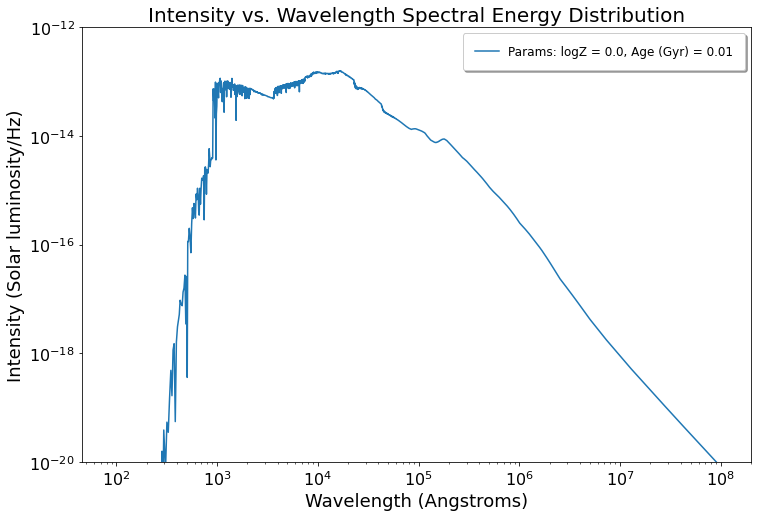

In [7]:
fig= plt.figure(figsize=(12,8)) # Making plot bigger

age_array = [0.01]
metallicity_array = [0]

for i in range(len(age_array)):
    metallicity = np.array([metallicity_array[i]])
    age         = np.array([age_array[i]])

    theta  = np.concatenate((metallicity, age))
    spec = interpolating_spec(theta)[0]

    plt_spectra(wave, spec, theta)

plt.title('Intensity vs. Wavelength Spectral Energy Distribution', fontsize = 20)
plt.ylabel('Intensity (Solar luminosity/Hz)', fontsize = 18) # Labeling the x-axis
plt.xlabel('Wavelength (Angstroms)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 12})
plt.ylim([1e-20,1e-12])
plt.savefig('descriptionSlidePlot.jpg', bbox_inches=0, dpi=600)
plt.show()

## Testing Accuracy of Interpolation Functions

In [30]:
age         = np.array([0.1])
metallicity = np.array([0])

theta  = np.concatenate((metallicity, age))
spec = interpolating_spec(theta)[0]

wave, obs_spec = make_spectrum(age[0], metallicity[0])

print(chi_sq_func(obs_spec, spec))

1.0066878372028618e-12
1.6401805686367186e-12


In [23]:
age         = np.array([0.1])
metallicity = np.array([0])

theta  = np.concatenate((metallicity, age))
mass = interpolating_mass(theta)[0][0]
print(mass)
sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, sfh=0, logzsol = metallicity[0], dust_type=2, dust2=0.0)
wave, obs_spec = sp.get_spectrum(tage = age[0])
exp_mass = sp.stellar_mass
print(exp_mass)
print((abs(mass - exp_mass)/exp_mass) * 100)

0.7963190704773087
0.790493806164769
0.7369146054163256


# Integrating MCMC Method

### Making a single test profile

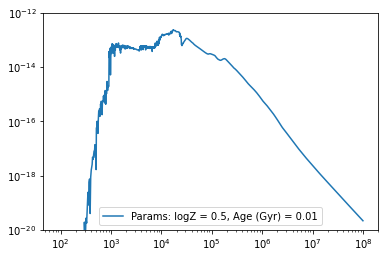

In [7]:
met = np.array([0.5])
age = np.array([0.01])

theta  = np.concatenate((met, age))
spec = interpolating_spec(theta)[0]

orig_values = np.array([met, age])

# Add error
snorm = spec + np.random.normal(0., 1e-24, len(wave))
enorm  = 1e-22 * np.ones((len(wave)))

plt_spectra(wave, snorm, theta)
plt.ylim([1e-20,1e-12])
plt.legend()
plt.show()

## Make a randon first guess; Compare with target; bad fit.

Metallicity Guess : -0.4 Age Guess : 1
Actual Metallicity: 0.5 Actual Age: 0.01


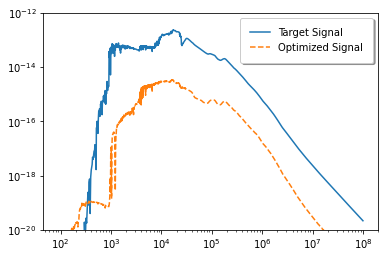

In [8]:
# Choosing random parameters
met_guess = np.array([-0.4])
age_guess = np.array([1])

print("Metallicity Guess :", met_guess[0], "Age Guess :", age_guess[0])
print("Actual Metallicity:", met[0], "Actual Age:", age[0])

theta  = np.concatenate((met_guess, age_guess))
spec_guess = model_guess(theta,wave, snorm)

# Add error
snorm_guess= spec_guess + np.random.normal(0., 1e-22, len(wave))
enorm_guess= 1e-22 * np.ones(len(wave))

plt.loglog(wave,snorm, label = "Target Signal")
plt.loglog(wave,snorm_guess, ls = '--', label = "Optimized Signal")
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.ylim([1e-20,1e-12])
plt.show()

Current Starting Position
0.4 0.008
Input values were (metallicity,age):
[0.5  0.01]
Optimizing Guess ***********
[0.51265591 0.00877713]


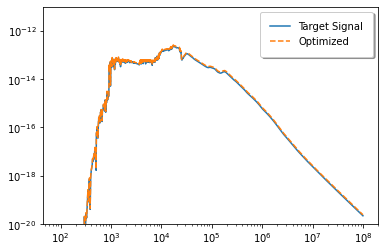

In [13]:
text_label=['met', 'age']
lb        = [-3, 0.001]
ub        = [1, 13]

met_ = 0.4
age_ = 0.008

initial_beta_guess = [met_, age_]
beta = initial_beta_guess

print("Current Starting Position")
print(met_, age_)
print("Input values were (metallicity,age):")
print(orig_values.flatten())

print('Optimizing Guess ***********')

popt = optimize_guess(model_guess, beta, lb, ub, wave, snorm, enorm)
print(popt)

spec_opt_guess= model_guess(popt, wave)

plt.loglog(wave, snorm, label='Target Signal')
plt.loglog(wave,spec_opt_guess, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.ylim([10**-20, 10**-11])
plt.show()

<ipython-input-12-a777372ecf61>:319: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Steps Taken:  1000 Likelihood:  131867.70244191677
Total steps to converge:  1000
Derived values are (weight array): 
 [0.5  0.01]


<ipython-input-12-a777372ecf61>:213: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


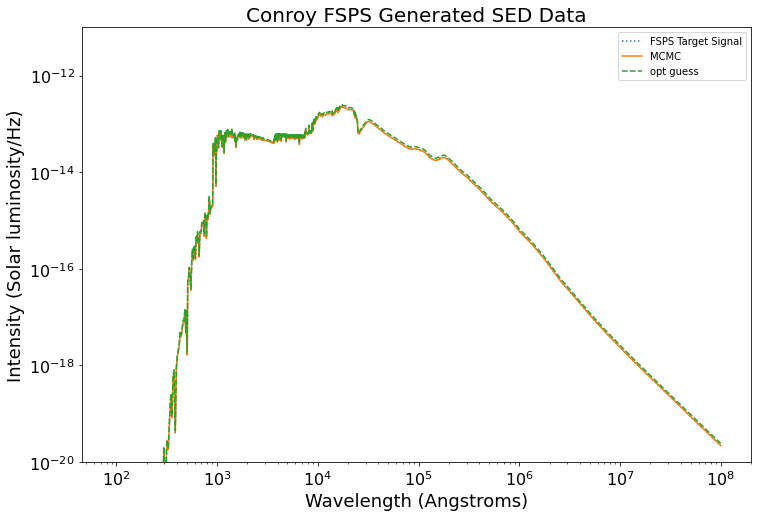

In [15]:
with Pool() as pool:    
    perturbation = popt * 0.01
    no_of_Chain = 250
    no_of_steps = 1000

    text_label=['met', 'age']
    lb        = [-3, 0.001]
    ub        = [1, 14]

    length_of_lb = len(lb)
    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

    guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, args=(lb, ub, model_guess, wave, snorm, enorm))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")
    
    break_steps = 5000
    convergence_accuracy = 1e-5
    convergence_check = True
    
    sampler, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, snorm, enorm, wave, model_guess)
    
    title = "Conroy FSPS Generated SED Data"
    galaxy = "FSPS Target Signal"

    best_fit1, param_array = print_and_plot_results(sampler, wave, snorm, title, galaxy, model_guess)
    
    plt.loglog(wave, best_fit1, label = "MCMC")
    plt.loglog(wave,spec_opt_guess,label='opt guess', ls='--')
    plt.legend()
    plt.ylim([10**-20, 10**-11])
    plt.show()

In [40]:
samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
print(st)
print(lnlike(st, model_guess, wave, snorm, enorm))

[0.5  0.01]
131867.69672972598


<ipython-input-40-1730edd59626>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


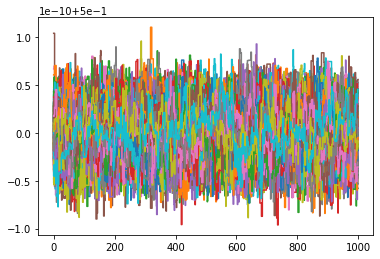

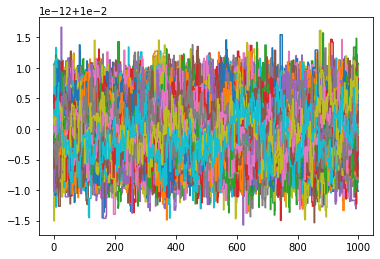

In [17]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))
sampler_ = np.array( sampler.chain )

for this_dim in range(sampler_.shape[2]):   # number of parameters
    for walker_nr in range(sampler_.shape[0]):
        plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
    plt.show()

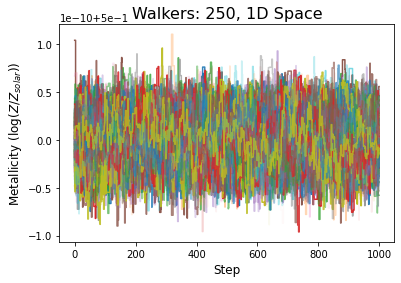

In [24]:
### For Saving an Image
for walker_nr in range(sampler_.shape[0]):
    plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,0], alpha = ((walker_nr) * (100/250)))
plt.title('Walkers: 250, 1D Space', fontsize = 16)
plt.ylabel('Metallicity (log($Z/Z_{solar}$))', fontsize = 12) # Labeling the x-axis
plt.xlabel('Step', fontsize = 12) # Labeling the y-axis
plt.savefig("Slide3_fig.jpg")
plt.show()

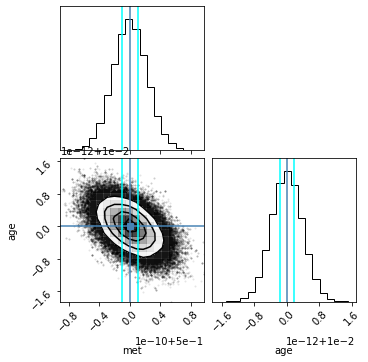

In [42]:
make_corner_plots(sampler)

# Galactic SED Fitting

### Making Spectrum Array

### Testing for a Galactic SED

In [8]:
metallicity_space = np.array([-3, 0, 1])
age_space = np.logspace(-3, 1.146, 10)

[1.215500e-03 8.723000e-03 5.033600e-02 1.317030e-01 2.079935e-01
 1.882595e-01 9.480900e-02 2.724150e-02 4.361500e-03 3.575000e-04
 1.100000e-02 8.500000e-02 3.355000e-01 9.445000e-01 1.437000e+00
 1.274500e+00 6.640000e-01 2.075000e-01 3.650000e-02 4.500000e-03
 1.016500e-03 7.169000e-03 3.049500e-02 8.875650e-02 1.453060e-01
 1.386185e-01 8.522550e-02 3.135100e-02 6.580500e-03 4.815000e-04]


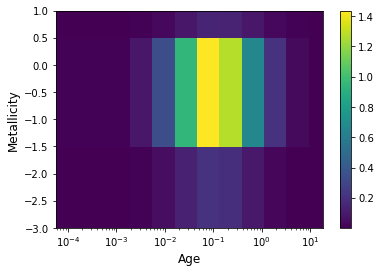

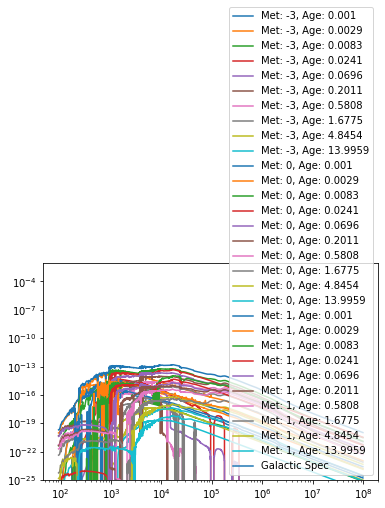

In [9]:
lb = 0
ub = int(5)

test_weight_array3 = np.array(generate_random_weight_array(lb, ub, metallicity_space, age_space))
plt.clf()
test_weight_array3 = test_weight_array3.flatten()
print(test_weight_array3)

row_array, column_array = convert_weight_array(test_weight_array3, metallicity_space, age_space)
met_array3, age_array3 = convert_arrays(row_array, column_array, metallicity_space, age_space)

# Printing Contour Map
plt.pcolormesh(age_space, metallicity_space, test_weight_array3.reshape((len(metallicity_space), len(age_space))), shading='auto')
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Metallicity', fontsize = 12)
plt.xscale('log')
plt.ylim([-3, 1])
plt.colorbar()
plt.show()
plt.clf()

test_weight_array3 = test_weight_array3.flatten()

total_spec3 = np.zeros(5994)

for i in range(len(met_array3)):
    met3 = np.array([met_array3[i]])
    age3 = np.array([age_array3[i]])
    
    theta3 = np.concatenate((met3, age3))
    spec3 = interpolating_spec(theta3)[0]
    spec3 *= test_weight_array3[i]
    plt.loglog(wave, spec3, label = "Met: {}, Age: {}".format(met3[0], age3[0]))
    total_spec3 += spec3

snorm3 = total_spec3 + np.random.normal(0., 1e-24, len(wave))
enorm3  = 1e-24 * np.ones((len(wave),))

plt.loglog(wave, snorm3, label = "Galactic Spec")
plt.legend()
plt.ylim([1e-25, 1e-2])
plt.show()

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
Input values were (metallicity,age):
[1.215500e-03 8.723000e-03 5.033600e-02 1.317030e-01 2.079935e-01
 1.882595e-01 9.480900e-02 2.724150e-02 4.361500e-03 3.575000e-04
 1.100000e-02 8.500000e-02 3.355000e-01 9.445000e-01 1.437000e+00
 1.274500e+00 6.640000e-01 2.075000e-01 3.650000e-02 4.500000e-03
 1.016500e-03 7.169000e-03 3.049500e-02 8.875650e-02 1.453060e-01
 1.386185e-01 8.522550e-02 3.135100e-02 6.580500e-03 4.815000e-04]
Optimizing Guess ***********


/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.08686114 0.10165186 0.00338524 0.03144123 0.0222299  0.01813954
 0.0189389  0.0171223  0.01322443 0.01155612 0.13422178 0.16053286
 0.33119787 0.0779025  0.05618844 0.03406046 0.02165281 0.01520097
 0.01177104 0.01074642 0.12190702 0.09658288 0.09234744 0.0539326
 0.03510678 0.02834531 0.01856542 0.01171598 0.01080738 0.0104802 ]


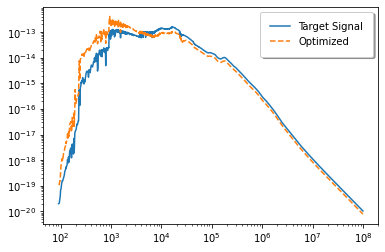

In [10]:
text_label = []

for i in range(30):
    text_label.append('mass'+ str(i))
    
lb   = np.zeros(30)
ub   = np.full(30, 1e10)

starting_weight_array = np.full(30, 0.01)

print("Current Starting Position")
print(starting_weight_array)
print("Input values were (metallicity,age):")
print(test_weight_array3)

print('Optimizing Guess ***********')

popt3 = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, wave, snorm3, enorm3)
print(popt3)

spec_opt_guess3 = galactic_model_guess(popt3, wave)

plt.loglog(wave, snorm3, label='Target Signal')
plt.loglog(wave,spec_opt_guess3, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.ylim([plt.ylim()[0], plt.ylim()[1]])
plt.show()

<ipython-input-2-e33223cb3068>:297: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Steps Taken:  5000 Likelihood:  -2.562916303933569e+20


<ipython-input-2-e33223cb3068>:236: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Derived values are (weight array): 
 [2.37464167e-03 7.15688967e-03 6.11186617e-02 1.26813062e-01
 1.05091034e-03 7.94791023e-01 4.73295164e-01 1.76521700e-01
 5.20847387e-01 1.45032047e-02 1.10202984e-02 8.49220595e-02
 3.32668480e-01 9.48017720e-01 1.46670549e+00 9.32464352e-01
 2.66392075e-01 6.60401799e-01 1.10949146e+00 9.73337980e-03
 6.04669538e-04 7.34732905e-03 2.88808619e-02 9.30851627e-02
 6.03333311e-03 3.70554783e-01 4.83384276e-02 1.89468397e-01
 3.83987199e-01 2.12666189e-03]
Input values are (weight array): 
 [1.215500e-03 8.723000e-03 5.033600e-02 1.317030e-01 2.079935e-01
 1.882595e-01 9.480900e-02 2.724150e-02 4.361500e-03 3.575000e-04
 1.100000e-02 8.500000e-02 3.355000e-01 9.445000e-01 1.437000e+00
 1.274500e+00 6.640000e-01 2.075000e-01 3.650000e-02 4.500000e-03
 1.016500e-03 7.169000e-03 3.049500e-02 8.875650e-02 1.453060e-01
 1.386185e-01 8.522550e-02 3.135100e-02 6.580500e-03 4.815000e-04]


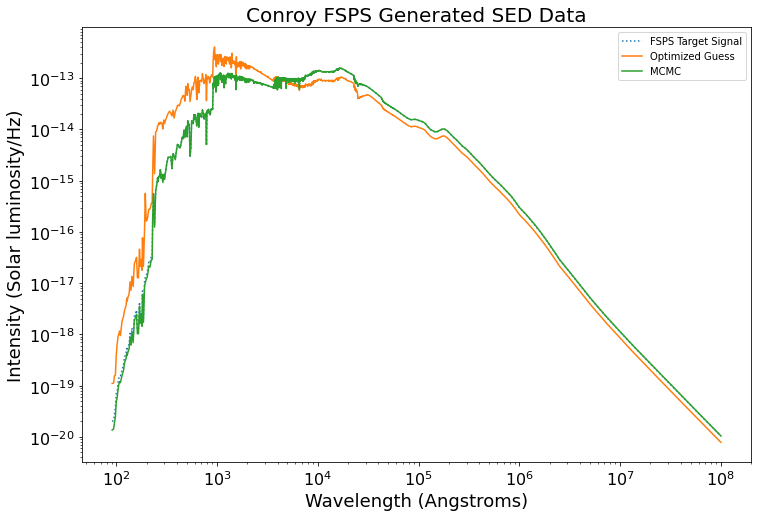

In [11]:
with Pool() as pool:
    perturbation = popt3 * 0.5
    no_of_Chain=500
    no_of_steps=5000

    text_label=[]

    for i in range(30):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(30)
    ub   = np.full(30, 1e9)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.
    
    filename = "7-20-2021_sampler_30.h5"
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)

    guesses = [popt3 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 2), args=(lb, ub, galactic_model_guess, wave, snorm3, enorm3), backend = backend)
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 5000
    convergence_accuracy = 1e-4
    convergence_check = False
    
    sampler_3D, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, snorm3, enorm3, wave, galactic_model_guess)
    
    title = "Conroy FSPS Generated SED Data"
    galaxy = "FSPS Target Signal"

    best_fit3, exp_weight_array3 = print_and_plot_results(sampler, wave, snorm3, title, galaxy, galactic_model_guess)
     
    print("Input values are (weight array): \n {}".format(test_weight_array3))

    plt.loglog(wave, spec_opt_guess3, label = "Optimized Guess")
    plt.loglog(wave, best_fit3, label = "MCMC")
    plt.legend()
    #plt.savefig("galactic_plot_10000_gaussian.jpg")
    plt.show()

## Reading in Sampler from File

In [25]:
filename = "7-20-2021_sampler_30.h5"
new_backend = emcee.backends.HDFBackend(filename)
test_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, backend=new_backend)

## Plotting Walkers

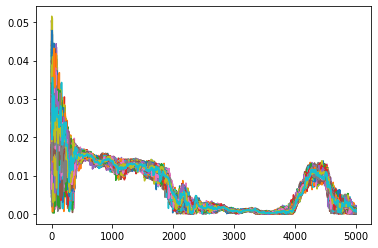

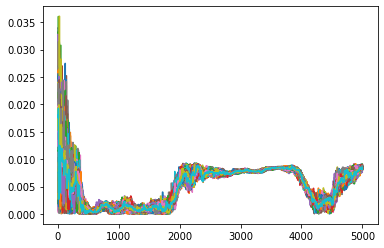

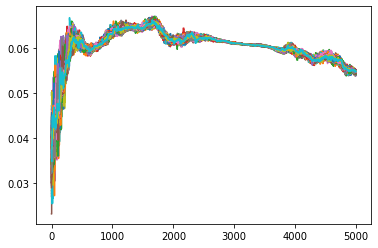

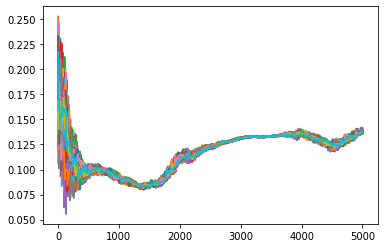

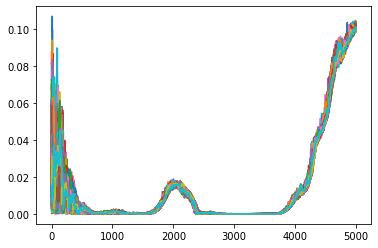

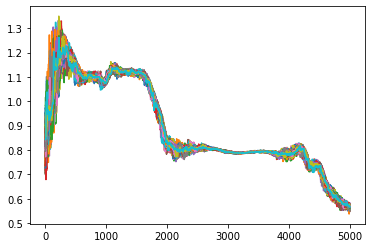

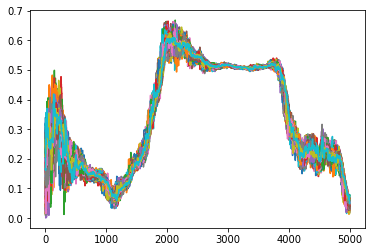

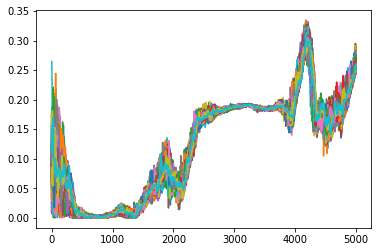

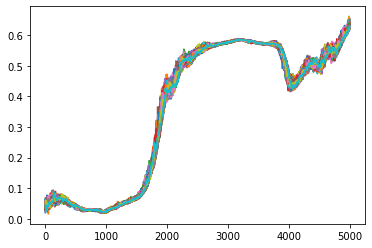

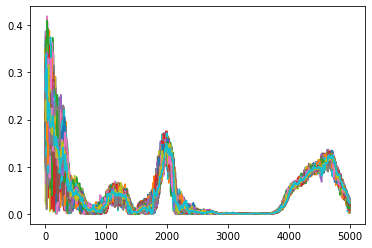

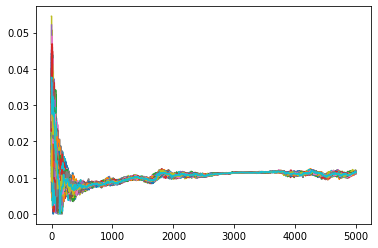

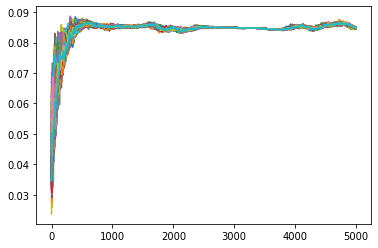

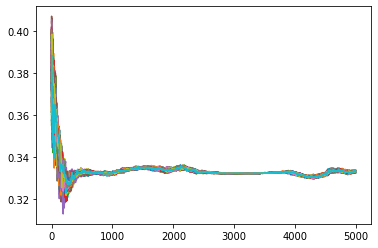

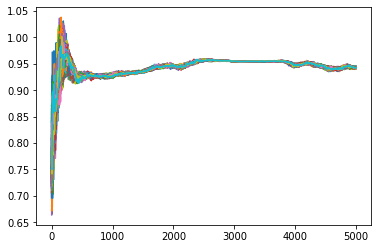

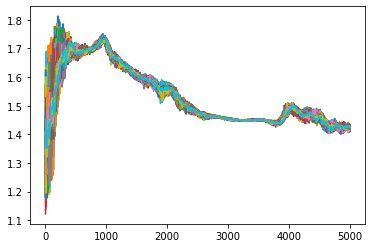

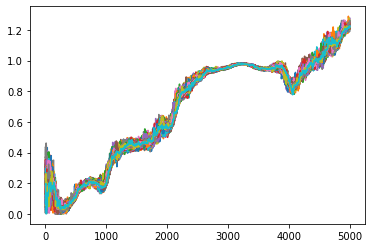

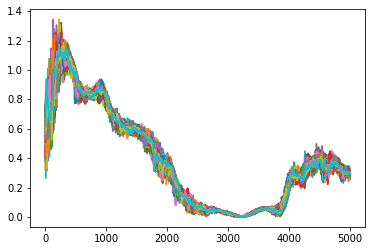

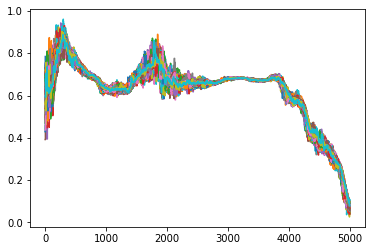

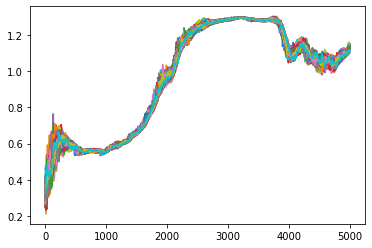

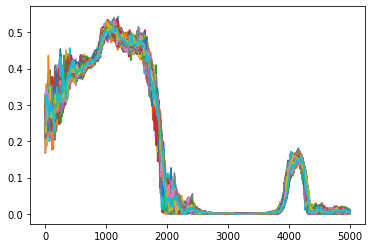

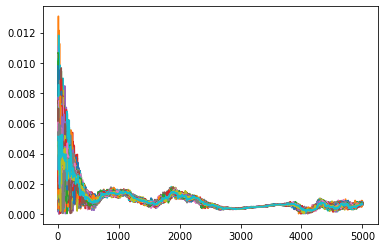

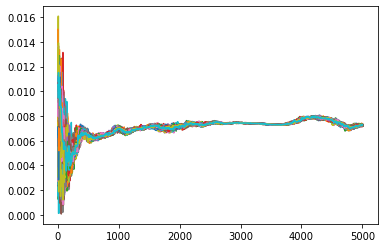

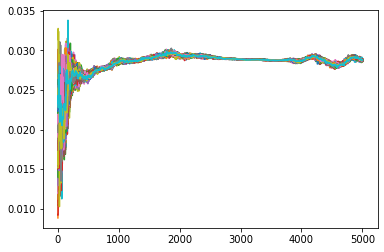

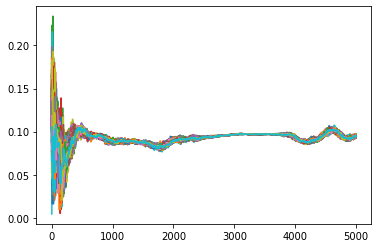

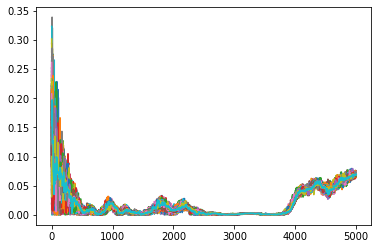

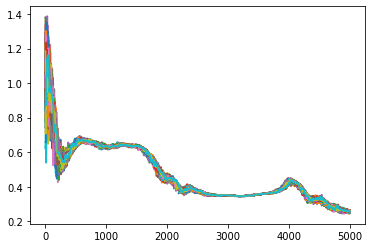

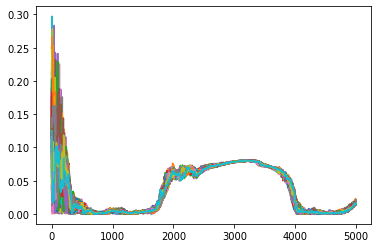

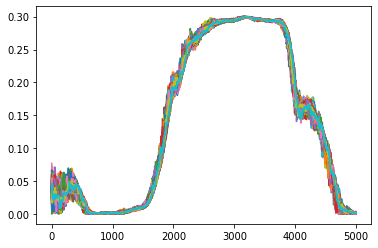

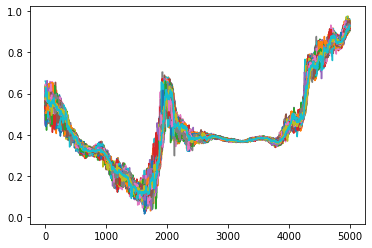

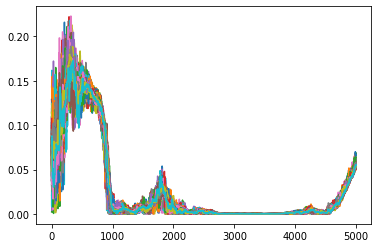

In [13]:
samples = sampler_3D.chain[:, :, :].reshape((-1, ndim))
sampler_ = np.array(sampler_3D.chain )

for this_dim in range(sampler_.shape[2]):   # number of parameters
    for walker_nr in range(sampler_.shape[0]):
        plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
    plt.show()

## Looking at Distributions

In [15]:
derived_weight = exp_weight_array3.reshape((3, 10))
input_weight = test_weight_array3.reshape((3, 10))

derived_age_dist = np.zeros(10)
input_age_dist = np.zeros(10)
derived_met_dist = np.zeros(3)
input_met_dist = np.zeros(3)
met_err = np.zeros(3)
age_err = np.zeros(10)

y_unc = np.array(get_uncertainty(sampler_3D))
y_unc = np.reshape(y_unc, (3,10))

for i in range(len(derived_weight)):
    for j in range(len(derived_weight[0])):
        derived_met_dist[i] += derived_weight[i][j]
        input_met_dist[i] += input_weight[i][j]
        met_err[i] += ((y_unc[i][j]) ** 2)
        

met_err = np.sqrt(met_err)

for i in range(len(derived_weight[0])):
    for j in range(len(derived_weight)):
        derived_age_dist[i] += derived_weight[j][i]
        input_age_dist[i] += input_weight[j][i]
        age_err[i] += (y_unc[j][i]) ** 2
    
age_err = np.sqrt(age_err)

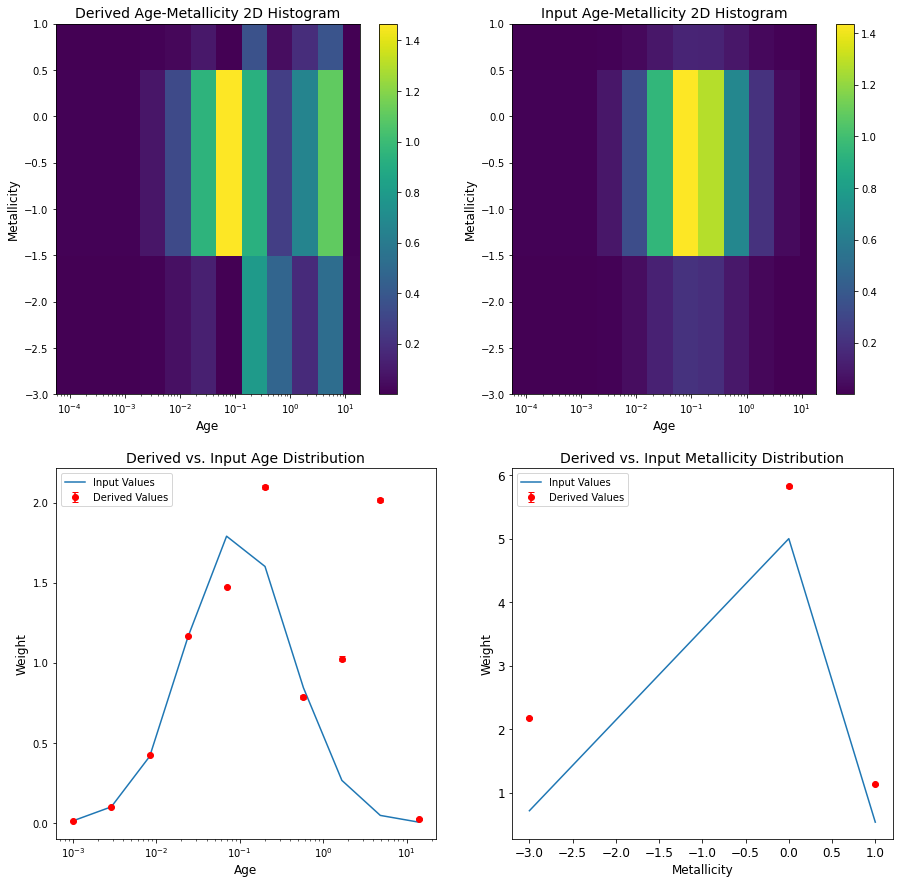

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
plt.tick_params(axis='both', which='major', labelsize=12)

plt1 = axs[0, 0].pcolormesh(age_space, metallicity_space, derived_weight, shading='auto')
axs[0, 0].set_title('Derived Age-Metallicity 2D Histogram', fontsize = 14)
plt2 = axs[0, 1].pcolormesh(age_space, metallicity_space, input_weight, shading='auto')
axs[0, 1].set_title('Input Age-Metallicity 2D Histogram', fontsize = 14)
axs[1, 0].errorbar(age_space, derived_age_dist, yerr = age_err, fmt = 'ro', ecolor = 'red', capsize = 3, ms = 6, label = "Derived Values")
axs[1, 0].plot(age_space, input_age_dist, 'tab:blue', label = "Input Values")
axs[1, 0].set_title('Derived vs. Input Age Distribution', fontsize = 14)
axs[1, 1].errorbar(metallicity_space, derived_met_dist, yerr = met_err, fmt = 'ro', ecolor = 'red', capsize = 3, ms = 6, label = "Derived Values")
axs[1, 1].plot(metallicity_space, input_met_dist, 'tab:blue', label = "Input Values")
axs[1, 1].set_title('Derived vs. Input Metallicity Distribution', fontsize = 14)

fig.colorbar(plt1, ax=axs[0, 0])
fig.colorbar(plt2, ax=axs[0, 1])

iterator = 0
for ax in axs.flat:
    if iterator == 0:
        ax.set_xlabel('Age', fontsize = 12)
        ax.set_ylabel('Metallicity', fontsize = 12)
        ax.set_xscale('log')
        ax.set_ylim([-3, 1])
    if iterator == 1:
        ax.set_xlabel('Age', fontsize = 12)
        ax.set_ylabel('Metallicity', fontsize = 12)
        ax.set_xscale('log')
        ax.set_ylim([-3, 1])
    if iterator == 2:
        ax.set_xlabel('Age', fontsize = 12)
        ax.set_ylabel('Weight', fontsize = 12)
        ax.set_xscale('log')
        ax.legend()
    if iterator == 3:
        ax.set_xlabel('Metallicity', fontsize = 12)
        ax.set_ylabel('Weight', fontsize = 12) 
        ax.legend()
    iterator += 1
    
plt.savefig("gauss_distributions_2.jpg")    
plt.show()

## Mass/Light PDF

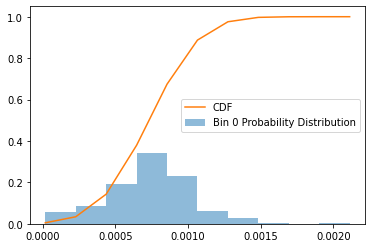

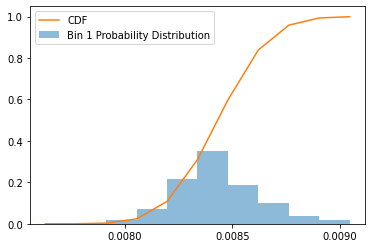

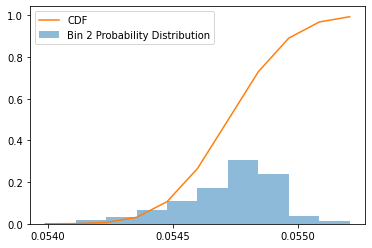

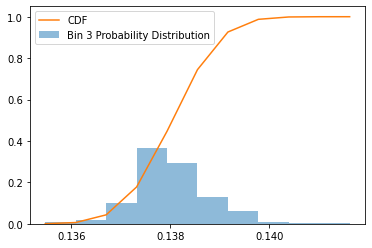

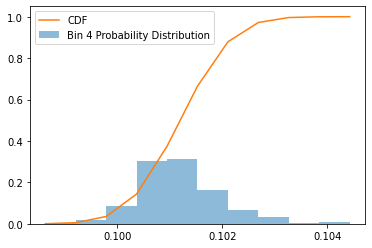

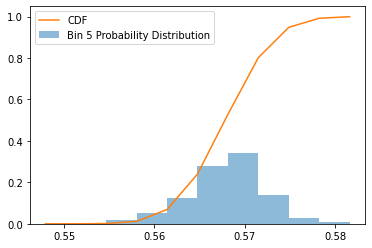

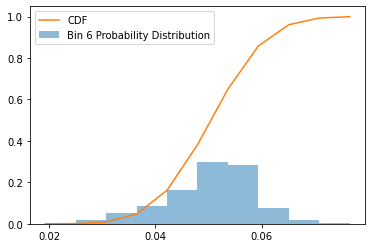

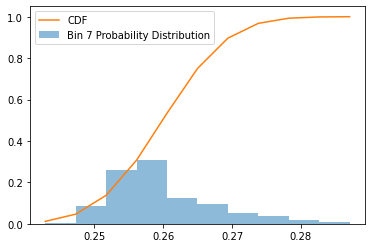

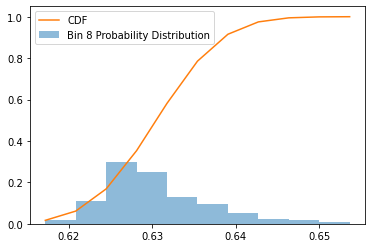

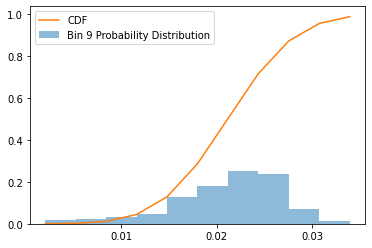

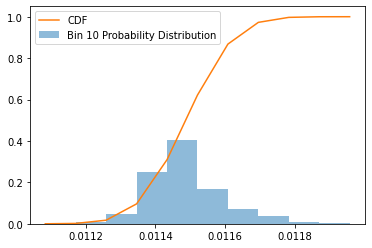

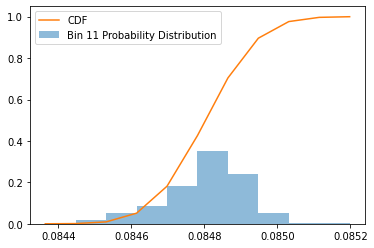

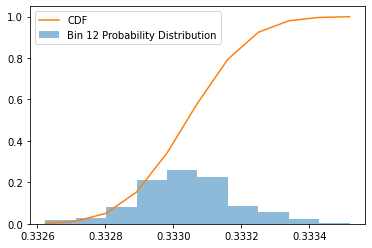

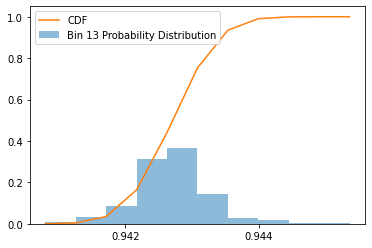

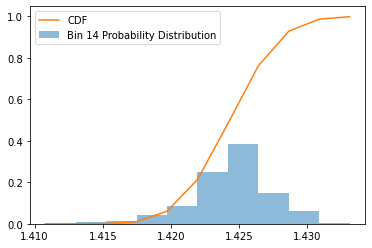

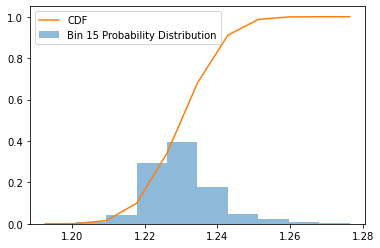

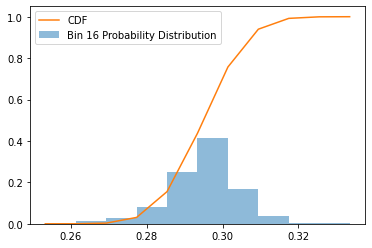

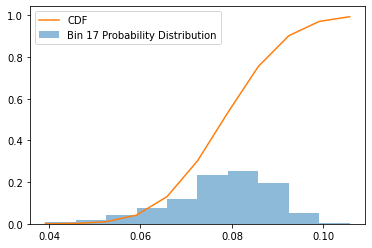

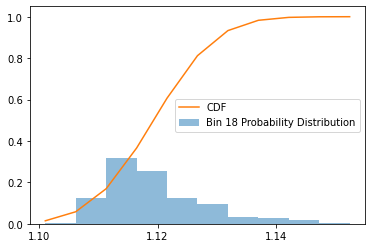

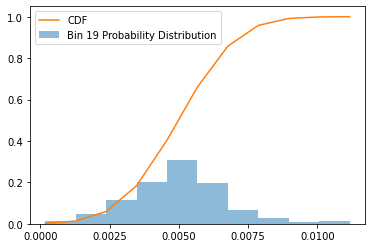

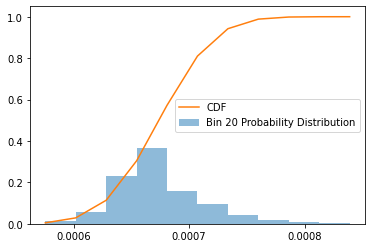

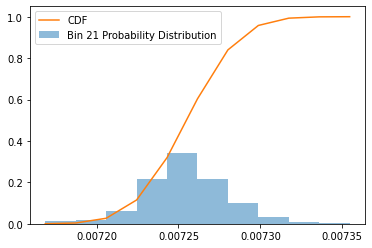

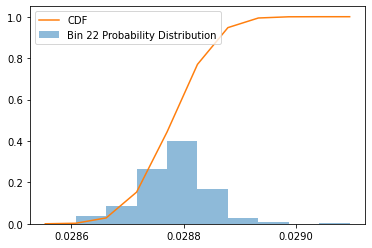

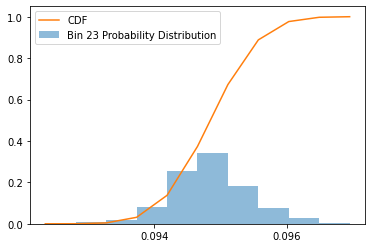

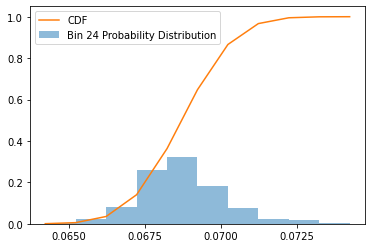

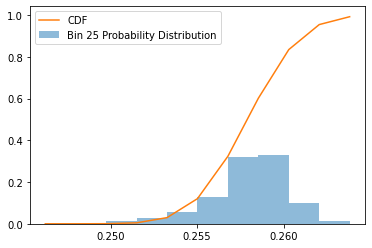

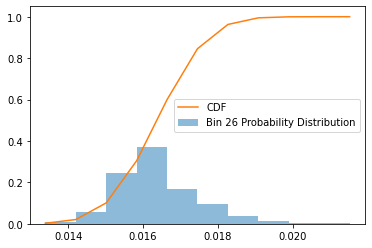

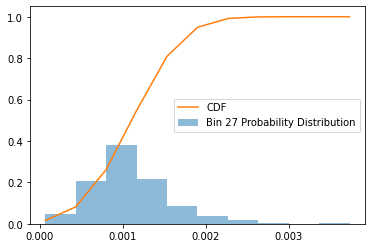

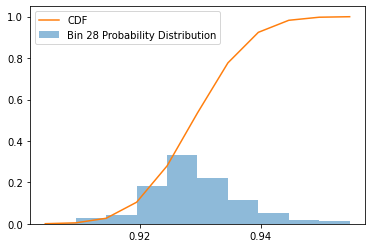

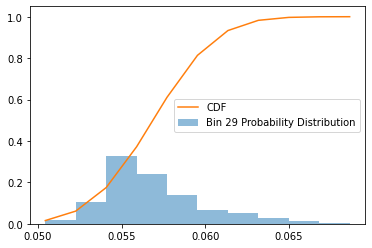

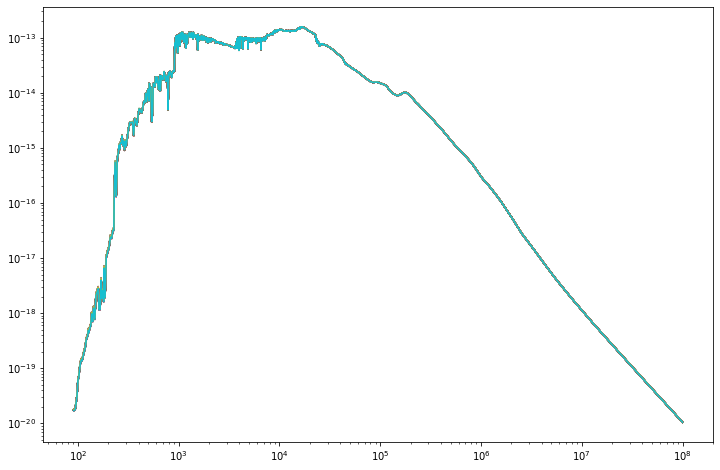

Derived Mass-to-light Ratio: 1.739e-02 +/- 4.845e-05
Input Mass-to-light Ratio: 1.321e-02
Standard Deviations Away: 86.270


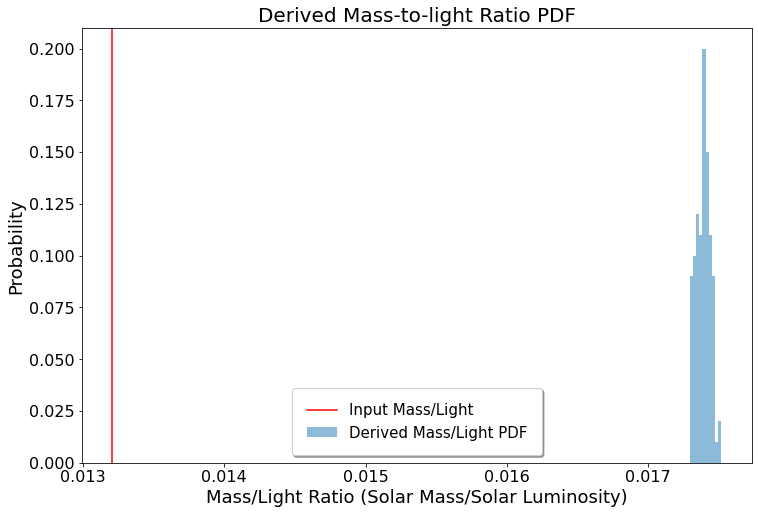

In [17]:
samples = 100
derived_mass_light, derived_mass_light_err = mass_light_pdf(sampler_3D, samples, snorm3, wave)
input_mass_light = mass_to_light_calc(test_weight_array3, snorm3, wave)

print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
plt.axvline(x = input_mass_light, color = 'red', label = "Input Mass/Light")
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.savefig("mass_light_pdf_3D.jpg")    
plt.show()

## Testing on Known Values

In [35]:
ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_obs_wave, ngc_4486_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_4486.dat")
ngc_4594_rest_wave, ngc_4594_flux, ngc_4594_obs_wave, ngc_4594_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_4594.dat")
ngc_4826_rest_wave, ngc_4826_flux, ngc_4826_obs_wave, ngc_4826_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_4826.dat")
ngc_3627_rest_wave, ngc_3627_flux, ngc_3627_obs_wave, ngc_3627_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_3627.dat")
ngc_4536_rest_wave, ngc_4536_flux, ngc_4536_obs_wave, ngc_4536_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_4536.dat")
ngc_5055_rest_wave, ngc_5055_flux, ngc_5055_obs_wave, ngc_5055_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_5055.dat")
ngc_7331_rest_wave, ngc_7331_flux, ngc_7331_obs_wave, ngc_7331_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_7331.dat")

In [36]:
derived_luminosity = []
known_luminosity = []
derived_array = []
known_array = []
gal_array = []

input_wave = ngc_3627_rest_wave
input_spec = ngc_3627_flux
mass = 176e9
luminosity = 36e9
gal_array.append("NGC 3627")
known_array.append(4.9)
derived_array.append(mass_to_light_calc(mass, input_spec, input_wave))
derived_luminosity.append(total_luminosity_calc(input_spec, input_wave))
known_luminosity.append(luminosity)

input_wave = ngc_4536_rest_wave
input_spec = ngc_4536_flux
mass = 210e9
luminosity = 44e9
gal_array.append("NGC 4536")
known_array.append(4.80)
derived_array.append(mass_to_light_calc(mass, input_spec, input_wave))
derived_luminosity.append(total_luminosity_calc(input_spec, input_wave))
known_luminosity.append(luminosity)

input_wave = ngc_4594_rest_wave
input_spec = ngc_4594_flux
mass = 590e9
luminosity = 10.5e9
gal_array.append("NGC 4594")
known_array.append(5.60)
derived_array.append(mass_to_light_calc(mass, input_spec, input_wave))
derived_luminosity.append(total_luminosity_calc(input_spec, input_wave))
known_luminosity.append(luminosity)

input_wave = ngc_4826_rest_wave
input_spec = ngc_4826_flux
mass = 71e9
luminosity = 15.6e9
gal_array.append("NGC 4826")
known_array.append(4.5)
derived_array.append(mass_to_light_calc(mass, input_spec, input_wave))
derived_luminosity.append(total_luminosity_calc(input_spec, input_wave))
known_luminosity.append(luminosity)

input_wave = ngc_5055_rest_wave
input_spec = ngc_5055_flux
mass = 230e9
luminosity = 50e9
gal_array.append("NGC 5055")
known_array.append(4.5)
derived_array.append(mass_to_light_calc(mass, input_spec, input_wave))
derived_luminosity.append(total_luminosity_calc(input_spec, input_wave))
known_luminosity.append(luminosity)

input_wave = ngc_7331_rest_wave
input_spec = ngc_7331_flux
mass = 390e9
luminosity = 85e9
gal_array.append("NGC 7331")
known_array.append(4.60)
derived_array.append(mass_to_light_calc(mass, input_spec, input_wave))
derived_luminosity.append(total_luminosity_calc(input_spec, input_wave))
known_luminosity.append(luminosity)



derived_array = [round(num,1) for num in derived_array]
derived_luminosity = [round(num,1) for num in derived_luminosity]
percent_error_ml = []
percent_error_luminosity = []

for i in range(len(derived_array)):
    percent_error_ml.append(abs((known_array[i]-derived_array[i])/known_array[i]) * 100)
    percent_error_luminosity.append(abs((known_luminosity[i]-derived_luminosity[i])/known_luminosity[i]) * 100)

percent_error_ml = [round(num,1) for num in percent_error_ml]
percent_error_luminosity = [round(num,1) for num in percent_error_luminosity]
print("Known M/L Values  : ", known_array)
print("Derived M/L Values: ", derived_array)
print("Percent Error M/L: ", percent_error_ml)
print("Known Luminosity Values  : ", known_luminosity)
print("Derived Luminosity Values: ", derived_luminosity)
print("Percent Error Luminosity: ", percent_error_luminosity)

#fig = plt.figure(figsize = (12, 8))
#x_pos = np.arange(len(gal_array))
#plt.bar(x_pos - 0.2, known_array, 0.4, align='center', label = "Known Values")
#plt.bar(x_pos + 0.2, derived_array, 0.4, align='center', label = "Derived Values")
#plt.title('Known vs. Derived M/L', fontsize = 20)
#plt.ylabel('Mass to Light (M/L)', fontsize = 18) # Labeling the x-axis
#plt.xlabel('Galaxy', fontsize = 18) # Labeling the y-axis
#plt.xticks(ticks = x_pos, labels = gal_array)
#plt.legend()
#plt.show()

ValueError: cannot reshape array of size 1 into shape (3,10)

## Removing Metallicity Dependence

In [17]:
metallicity_space = np.array([0])
age_space = np.logspace(-3, 1, 10)

[0.00025063 0.00434417 0.02949025 0.12163682 0.23174487 0.24686593
 0.14669935 0.04745173 0.00601501 0.00091896]


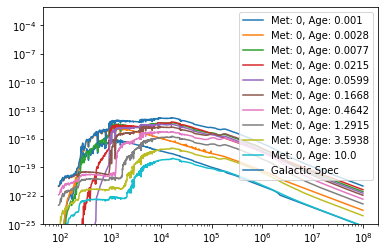

In [18]:
lb = 0
ub = int(10)

test_weight_array4 = np.array(generate_random_weight_array(lb, ub, metallicity_space, age_space))
plt.clf()
test_weight_array4 = test_weight_array4.flatten()
print(test_weight_array4)

row_array, column_array = convert_weight_array(test_weight_array4, metallicity_space, age_space)
met_array4, age_array4 = convert_arrays(row_array, column_array, metallicity_space, age_space)

total_spec4 = np.zeros(5994)

for i in range(len(met_array4)):
    met4 = np.array([met_array4[i]])
    age4 = np.array([age_array4[i]])
    
    theta4 = np.concatenate((met4, age4))
    spec4 = interpolating_spec(theta4)[0]
    spec4 *= test_weight_array4[i]
    plt.loglog(wave, spec4, label = "Met: {}, Age: {}".format(met4[0], age4[0]))
    total_spec4 += spec4

snorm4 = total_spec4 + np.random.normal(0., 1e-24, len(wave))
enorm4  = 1e-24 * np.ones((len(wave),))

plt.loglog(wave, snorm4, label = "Galactic Spec")
plt.legend()
plt.ylim([1e-25, 1e-2])
plt.show()

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Input values were (metallicity,age):
[0.00025063 0.00434417 0.02949025 0.12163682 0.23174487 0.24686593
 0.14669935 0.04745173 0.00601501 0.00091896]
Optimizing Guess ***********


/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimiz

[0.02128411 0.00282049 0.0690641  0.02519477 0.02759999 0.11568338
 0.08774222 0.04659389 0.00764853 0.00399469]


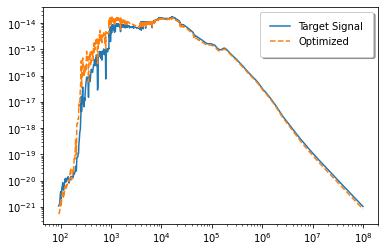

In [19]:
text_label = []

for i in range(10):
    text_label.append('mass'+ str(i))
    
lb   = np.zeros(10)
ub   = np.full(10, 1e10)

starting_weight_array = np.full(10, 0.01)

print("Current Starting Position")
print(starting_weight_array)
print("Input values were (metallicity,age):")
print(test_weight_array4)

print('Optimizing Guess ***********')

popt4 = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, wave, snorm4, enorm4)
print(popt4)

spec_opt_guess4 = galactic_model_guess(popt4, wave)

plt.loglog(wave, snorm4, label='Target Signal')
plt.loglog(wave,spec_opt_guess4, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.ylim([plt.ylim()[0], plt.ylim()[1]])
plt.show()

In [25]:
with Pool() as pool:
    perturbation = popt4 * 0.01
    no_of_Chain=500
    no_of_steps=5000

    text_label=[]

    for i in range(10):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(10)
    ub   = np.full(10, 5)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

    guesses = [popt4 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 2), args=(lb, ub, galactic_model_guess, wave, snorm4, enorm4))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 10000
    convergence_accuracy = 1e-5
    convergence_check = False
    
    sampler_1D, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, snorm4, enorm4, wave, galactic_model_guess)
    
    title = "Conroy FSPS Generated SED Data"
    galaxy = "FSPS Target Signal"

    best_fit4, exp_weight_array4 = print_and_plot_results(sampler_1D, wave, snorm4, title, galaxy, galactic_model_guess)

    print("Input values are (weight array): \n {}".format(test_weight_array4))
    
    plt.loglog(wave, spec_opt_guess4, label = "Optimized Guess")
    plt.loglog(wave, best_fit4, label = "MCMC")
    plt.legend()
    plt.savefig("galactic_plot_log_10000_gaussian_1D.jpg")
    plt.show()

Starting emcee ***********
Start Burntime Calculations ***********


  0%|          | 4/1000 [00:00<03:24,  4.87it/s]Process ForkPoolWorker-275:
Process ForkPoolWorker-361:
Process ForkPoolWorker-272:
Process ForkPoolWorker-297:
Process ForkPoolWorker-292:
Process ForkPoolWorker-313:


emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-366:
Process ForkPoolWorker-344:
Process ForkPoolWorker-312:
Process ForkPoolWorker-290:
Process ForkPoolWorker-373:
Process ForkPoolWorker-374:
Process ForkPoolWorker-286:
Process ForkPoolWorker-342:
Process ForkPoolWorker-299:
Process ForkPoolWorker-298:
Process ForkPoolWorker-351:


emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-332:
Process ForkPoolWorker-338:
Process ForkPoolWorker-328:
Process ForkPoolWorker-339:
Process ForkPoolWorker-368:
Process ForkPoolWorker-376:
Process ForkPoolWorker-343:
Process ForkPoolWorker-347:
Process ForkPoolWorker-279:
Process ForkPoolWorker-295:
Process ForkPoolWorker-341:
Process ForkPoolWorker-382:
Process ForkPoolWorker-322:
Process ForkPoolWorker-309:
Process ForkPoolWorker-294:
Process ForkPoolWorker-285:
Process ForkPoolWorker-326:
Process ForkPoolWorker-265:
Process ForkPoolWorker-291:
Process ForkPoolWorker-303:
Process ForkPoolWorker-335:
Process ForkPoolWorker-345:
Process ForkPoolWorker-370:
Process ForkPoolWorker-352:
Process ForkPoolWorker-287:
Process ForkPoolWorker-288:
Process ForkPoolWorker-284:
Process ForkPoolWorker-259:


emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-362:
Process ForkPoolWorker-372:
Process ForkPoolWorker-273:
Process ForkPoolWorker-327:
Process ForkPoolWorker-271:
Process ForkPoolWorker-363:
Process ForkPoolWorker-378:
Process ForkPoolWorker-380:
Process ForkPoolWorker-353:
Process ForkPoolWorker-301:
Process ForkPoolWorker-329:
Process ForkPoolWorker-293:
Process ForkPoolWorker-300:
Process ForkPoolWorker-306:
Process ForkPoolWorker-324:
Process ForkPoolWorker-331:
Process ForkPoolWorker-383:
Process ForkPoolWorker-307:
Process ForkPoolWorker-354:
Process ForkPoolWorker-325:


emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-263:
Process ForkPoolWorker-280:
Process ForkPoolWorker-278:
Process ForkPoolWorker-330:
Process ForkPoolWorker-260:
Process ForkPoolWorker-360:
Process ForkPoolWorker-289:
Process ForkPoolWorker-336:
Process ForkPoolWorker-269:
Process ForkPoolWorker-337:
Process ForkPoolWorker-268:
Process ForkPoolWorker-379:
Process ForkPoolWorker-375:
Process ForkPoolWorker-264:
Process ForkPoolWorker-310:
Process ForkPoolWorker-276:


emcee: Exception while calling your likelihood function:


Process ForkPoolWorker-348:
Process ForkPoolWorker-364:
Process ForkPoolWorker-321:
Process ForkPoolWorker-257:
Process ForkPoolWorker-262:
Process ForkPoolWorker-356:
Process ForkPoolWorker-350:
Process ForkPoolWorker-282:
Process ForkPoolWorker-261:
Process ForkPoolWorker-296:
Process ForkPoolWorker-281:
Process ForkPoolWorker-318:
Process ForkPoolWorker-357:
Process ForkPoolWorker-365:
Process ForkPoolWorker-266:


emcee: Exception while calling your likelihood function:
  params: [0.0213091  0.00287312 0.06999047 0.02524927 0.0275542  0.11964512
 0.08937718 0.04819014 0.00774059 0.00388223]

Process ForkPoolWorker-274:
Process ForkPoolWorker-319:
Process ForkPoolWorker-323:
Process ForkPoolWorker-270:
Process ForkPoolWorker-377:
Traceback (most recent call last):
Process ForkPoolWorker-359:
Process ForkPoolWorker-358:
Process ForkPoolWorker-308:
Process ForkPoolWorker-355:
Process ForkPoolWorker-371:
Process ForkPoolWorker-277:
Process ForkPoolWorker-316:
Process ForkPoolWorker-340:
Process ForkPoolWorker-315:
Process ForkPoolWorker-349:
Process ForkPoolWorker-283:
Traceback (most recent call last):
Process ForkPoolWorker-334:
Process ForkPoolWorker-258:
Process ForkPoolWorker-346:
Process ForkPoolWorker-333:
Process ForkPoolWorker-267:
Process ForkPoolWorker-304:
Process ForkPoolWorker-367:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-381:
Traceback (most recent call last):
Process ForkPoolWorker-314:
Process ForkPoolWorker-369:


  params: [0.02115078 0.00281155 0.06899072 0.02520567 0.02754415 0.11777791
 0.08772643 0.04647725 0.00750777 0.00392392]

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


  params: [0.02137707 0.00284212 0.06939741 0.02515776 0.0278499  0.11609635
 0.08746285 0.04638607 0.00779716 0.00397221]

Traceback (most recent call last):
Traceback (most recent call last):


  params: [0.02154758 0.00278782 0.06967309 0.02519517 0.02746515 0.11625431
 0.08536336 0.04698136 0.00767024 0.00400487]

Traceback (most recent call last):
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()



  params: [0.02126852 0.00282381 0.06897736 0.02497211 0.02750164 0.11673833
 0.08795172 0.04652622 0.007652   0.00399173]

  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


  params: [0.02100076 0.00284329 0.06951066 0.02557562 0.02753924 0.11497405
 0.08658603 0.04675817 0.00781685 0.00402482]

  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py"

  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task

  args: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), <function galactic_model_guess at 0x2af457ec8e50>, array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
       1.000e+08]), array([1.08908956e-21, 1.18837273e-21, 1.50720748e-21, ...,
       1.08109981e-21, 1.06289756e-21, 1.04045657e-21]), array([1.e-24, 1.e-24, 1.e-24, ..., 1.e-24, 1.e-24, 1.e-24]))

  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  args: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), <function galactic_model_guess at 0x2af457ec8e50>, array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
       1.000e+08]), array([1.08908956e-21, 1.18837273e-21, 1.50720748e-21, ...,
       1.08109981e-21, 1.06289756e-21, 1.04045657e-21]), array([1.e-24, 1.e-24, 1.e-24, ..., 1.e-24, 1.e-24, 1.e-24]))  args: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), <function galactic_model_guess at 0x2af457ec8e50>, array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
       1.000e+08]), array([1.08908956e-21, 1.18837273e-21, 1.50720748e-21, ...,
       1.08109981e-21, 1.06289756e-21, 1.04045657e-21]), array([1.e-24, 1.e-24, 1.e-24, ..., 1.e-24, 1.e-24, 1.e-24]))

  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:


  args: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), <function galactic_model_guess at 0x2af457ec8e50>, array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
       1.000e+08]), array([1.08908956e-21, 1.18837273e-21, 1.50720748e-21, ...,
       1.08109981e-21, 1.06289756e-21, 1.04045657e-21]), array([1.e-24, 1.e-24, 1.e-24, ..., 1.e-24, 1.e-24, 1.e-24]))

  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  args: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), <function galactic_model_guess at 0x2af457ec8e50>, array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
       1.000e+08]), array([1.08908956e-21, 1.18837273e-21, 1.50720748e-21, ...,
       1.08109981e-21, 1.06289756e-21, 1.04045657e-21]), array([1.e-24, 1.e-24, 1.e-24, ..., 1.e-24, 1.e-24, 1.e-24]))  args: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), <function galactic_model_guess at 0x2af457ec8e50>, array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
       1.000e+08]), array([1.08908956e-21, 1.18837273e-21, 1.50720748e-21, ...,
       1.08109981e-21, 1.06289756e-21, 1.04045657e-21]), array([1.e-24, 1.e-24, 1.e-24, ..., 1.e-24, 1.e-24, 1.e-24]))

  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:


  kwargs: {}


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


  kwargs: {}


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


  kwargs: {}
  kwargs: {}


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


  exception:


KeyboardInterrupt


  kwargs: {}


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


  kwargs: {}


  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt


  exception:
  exception:
  exception:


KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


  exception:


KeyboardInterrupt
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()


  exception:


KeyboardInterrupt
KeyboardInterrupt
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt

Traceback (most recent call last):
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


EOFError: Ran out of input

KeyboardInterrupt
  File "<ipython-input-24-b5ffad1eddd3>", line 184, in galactic_spec
    spec = interpolating_spec(theta)[0]
  File "<ipython-input-24-b5ffad1eddd3>", line 408, in lnprob
    return lp + lnlike(theta, model, x, y, yerr)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "<ipython-input-24-b5ffad1eddd3>", line 396, in lnlike
    model_y = model(theta, x)
KeyboardInterrupt
KeyboardInterrupt
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "<ipython-input-24-b5ffad1eddd3>", line 203, in galactic_model_guess
    total_spec = galactic_spec(weight_array)
  File "/apps/jupyterhub/1.1.0/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter_

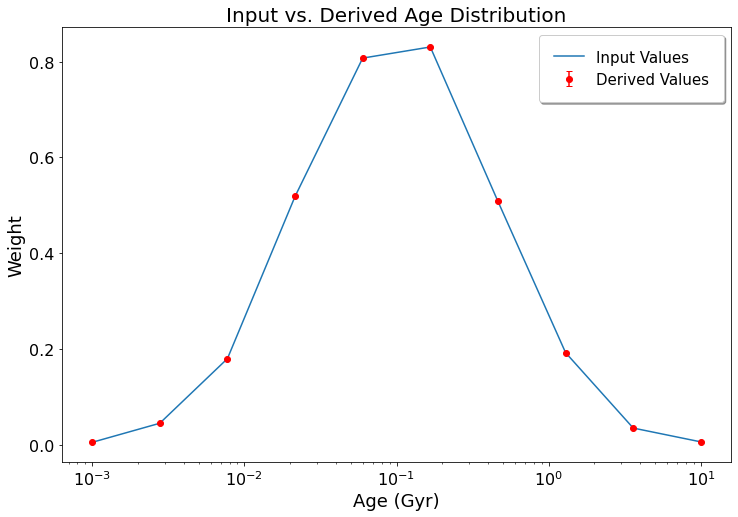

In [123]:
fig= plt.figure(figsize=(12,8))
y_unc = np.array(get_uncertainty(sampler_1D))
y_unc_norm = []
for i in range(len(y_unc)):
    y_unc_norm.append(y_unc[i] * norm_factor)
plt.errorbar(age_space, norm_array, yerr = y_unc, fmt = 'ro', ecolor = 'red', capsize = 3, ms = 6, label = "Derived Values")
#plt.errorbar(age_space, exp_weight_array4, yerr = y_unc_norm, fmt = 'bo', ecolor = 'blue', capsize = 3, ms = 6, label = "Normalized Derived Values")
plt.plot(age_space, test_weight_array4, 'tab:blue', label = "Input Values")
plt.xscale("log")
plt.title('Input vs. Derived Age Distribution', fontsize = 20)
plt.ylabel('Weight', fontsize = 18) # Labeling the x-axis
plt.xlabel('Age (Gyr)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  
plt.savefig("gauss_distributions_1D_2.jpg")    
plt.show()

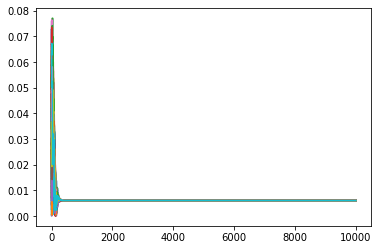

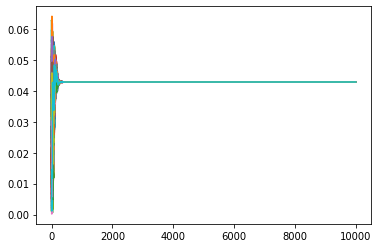

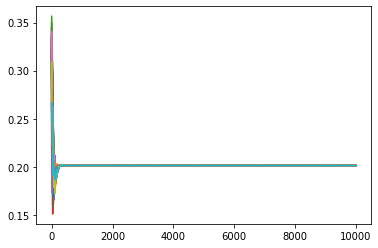

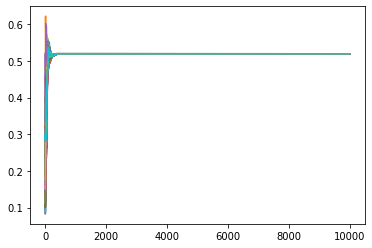

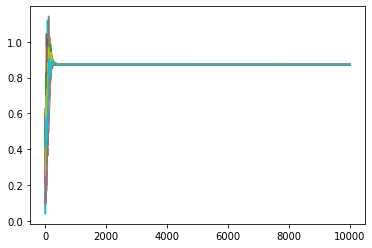

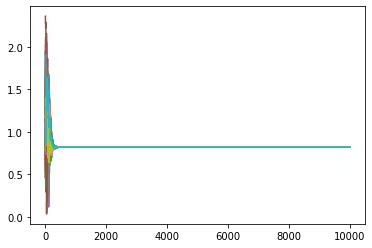

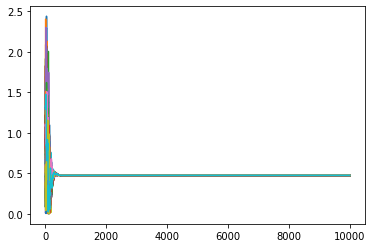

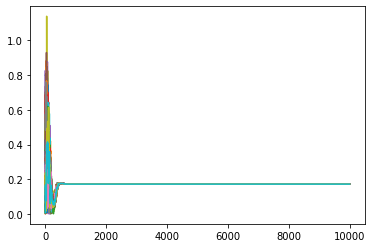

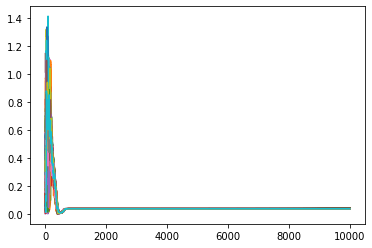

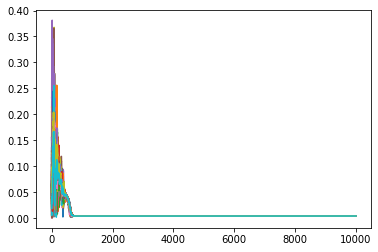

In [40]:
samples = sampler_1D.chain[:, :, :].reshape((-1, ndim))
sampler_ = np.array( sampler_1D.chain )

for this_dim in range(sampler_.shape[2]):   # number of parameters
    for walker_nr in range(sampler_.shape[0]):
        plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
    plt.show()


### For Saving an Image
#for walker_nr in range(sampler_.shape[0]):
    #plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
#plt.title('Walkers: 500, 1D Space', fontsize = 16)
#plt.ylabel('Metallicity (log($Z/Z_{solar}$)', fontsize = 12) # Labeling the x-axis
#plt.xlabel('Step', fontsize = 12) # Labeling the y-axis
#plt.savefig("Slide3_fig.jpg")
#plt.show()

## Mass/Light PDFs

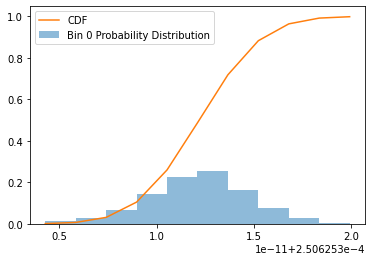

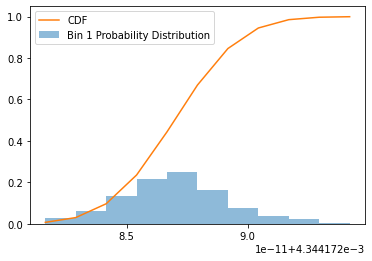

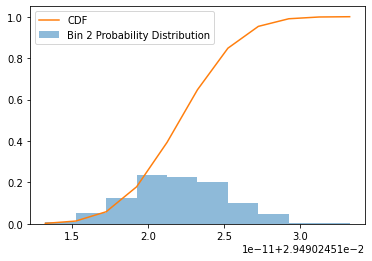

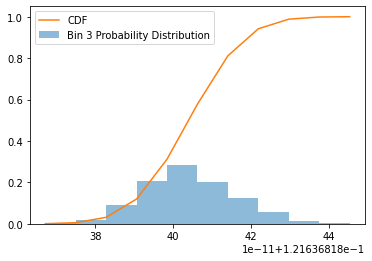

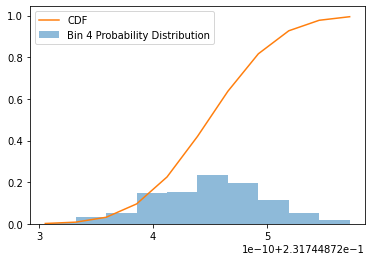

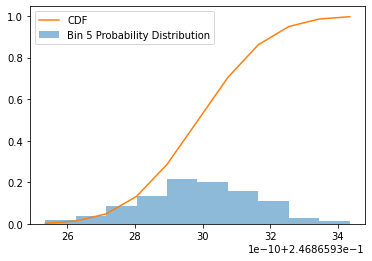

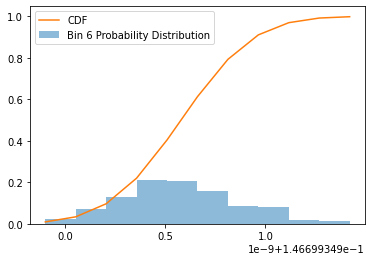

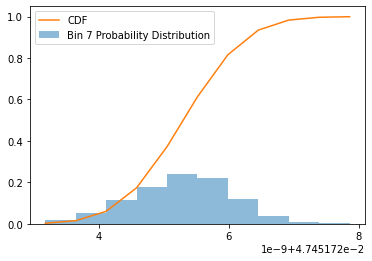

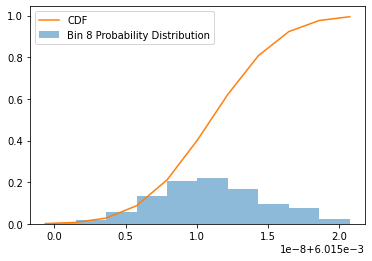

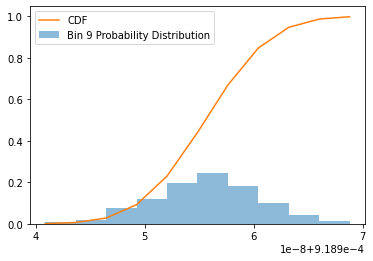

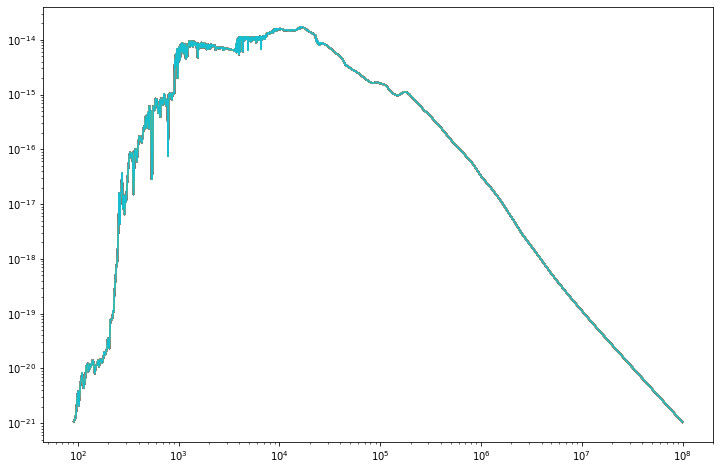

Derived Mass-to-light Ratio: 2.920e-02 +/- 1.988e-10
Input Mass-to-light Ratio: 2.920e-02
Standard Deviations Away: 0.155


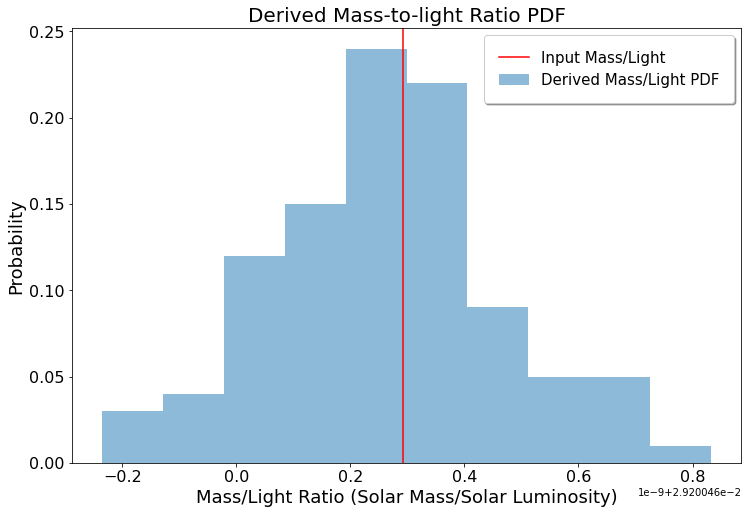

In [26]:
samples = 100
derived_mass_light, derived_mass_light_err, input_mass_light = mass_light_pdf(sampler_1D, samples, test_weight_array4, snorm4, wave)

print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.savefig("mass_light_pdf_1D.jpg")    
plt.show()

## Observable Data

In [ ]:
ngc_337_rest_wave, ngc_337_flux, ngc_337_obs_wave, ngc_337_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_337.dat")
ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_obs_wave, ngc_4486_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_4486.dat")
ngc_4594_rest_wave, ngc_4594_flux, ngc_4594_obs_wave, ngc_4594_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_4594.dat")
ngc_4826_rest_wave, ngc_4826_flux, ngc_4826_obs_wave, ngc_4826_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_4826.dat")
ngc_4486_flux_err  = 1e-24 * np.ones(len(ngc_4486_flux))

In [ ]:
fig= plt.figure(figsize=(12,8))
plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label='NGC 4486')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.show()

### 1 Parameter

In [52]:
metallicity_space = np.array([-0.3])
age_space = np.array([13.24])

Current Starting Position
[0.01]
Optimizing Guess ***********
[0.01]


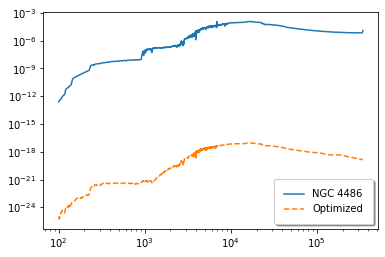

In [54]:
lb   = np.zeros(1)
ub   = np.full(1, 1e15)

starting_weight_array = np.zeros(1) + 0.01

print("Current Starting Position")
print(starting_weight_array)
print('Optimizing Guess ***********')

popt = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err)
print(popt)

ngc_4486_opt_guess= galactic_model_guess(popt, ngc_4486_rest_wave)

plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label='NGC 4486')
plt.loglog(ngc_4486_rest_wave, ngc_4486_opt_guess, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.show()

## MCMC Fit

Steps Taken:  1000 Likelihood:  -1.766784854796903e+40
Derived values are (weight array): 
 [1.14387335e+11]


<ipython-input-26-bc449b0381d2>:342: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
<ipython-input-26-bc449b0381d2>:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

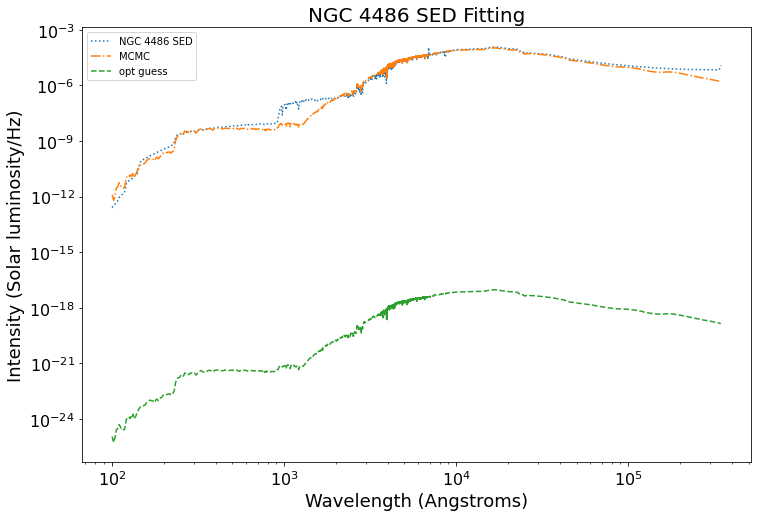

In [55]:
with Pool() as pool:
    perturbation = popt * 0.01
    no_of_Chain=500
    no_of_steps=1000

    text_label=[]

    for i in range(1):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(1)
    ub   = np.full(1, 1e12)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

    guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 5), args=(lb, ub, galactic_model_guess, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 1000
    convergence_accuracy = 1e-4
    convergence_check = False
    
    sampler1, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, ngc_4486_flux, ngc_4486_flux_err, ngc_4486_rest_wave, galactic_model_guess)

    title = "NGC 4486 SED Fitting"
    galaxy = "NGC 4486 SED"
    
    best_fit1, exp_weight_array1 = print_and_plot_results(sampler, ngc_4486_rest_wave, ngc_4486_flux, title, galaxy, galactic_model_guess)
    
    plt.loglog(ngc_4486_rest_wave, best_fit1, label = "MCMC", ls = '-.')
    plt.loglog(ngc_4486_rest_wave,ngc_4486_opt_guess,label='opt guess', ls='--')
    plt.legend()
    plt.savefig("ngc_4486.jpg")
    plt.show()

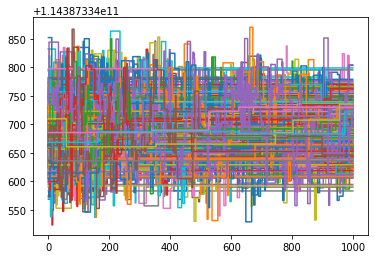

In [56]:
samples = sampler1.chain[:, :, :].reshape((-1, ndim))
sampler_ = np.array( sampler1.chain )

for this_dim in range(sampler_.shape[2]):   # number of parameters
    for walker_nr in range(sampler_.shape[0]):
        plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
    plt.show()

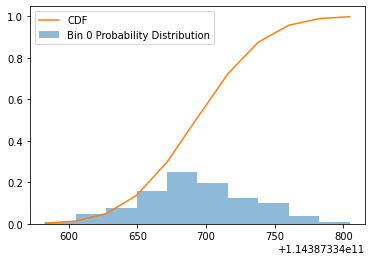

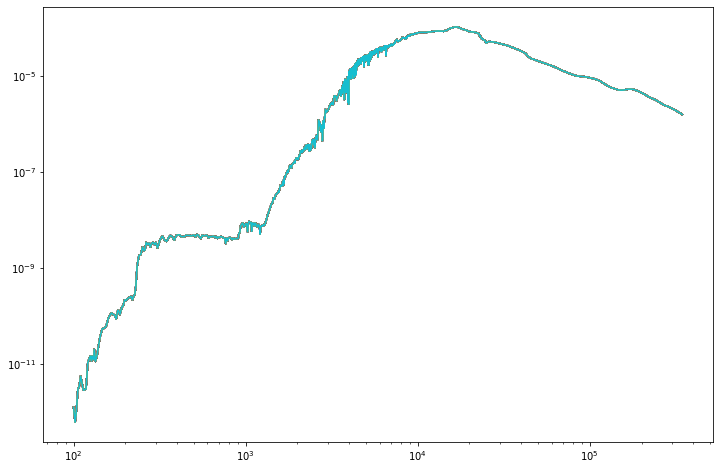

Derived Mass-to-light Ratio: 1.848e+00 +/- 4.242e-16
Input Mass-to-light Ratio: 6.300e+00
Standard Deviations Away: 10495685779483820.000


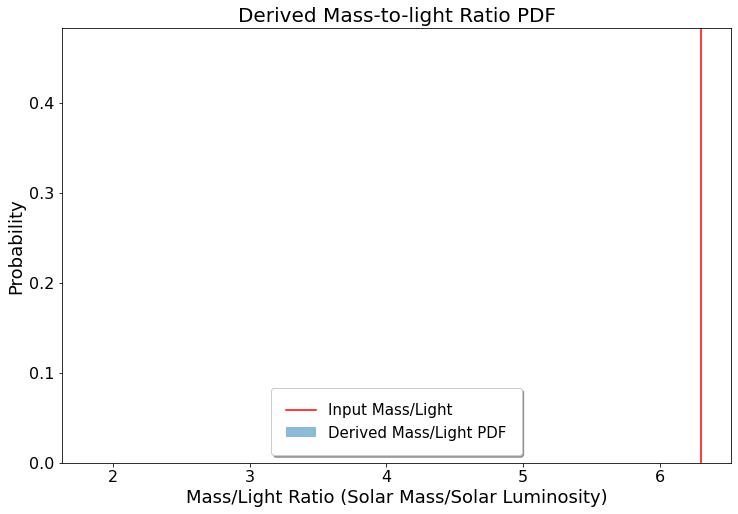

In [57]:
samples = 100
derived_mass_light, derived_mass_light_err = mass_light_pdf(sampler1, samples, ngc_4486_flux, ngc_4486_rest_wave)
input_mass_light = 6.3

print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
plt.axvline(x = input_mass_light, color = 'red', label = "Input Mass/Light")
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.savefig("mass_light_pdf_3D.jpg")    
plt.show()

### 2 Parameter

In [58]:
metallicity_space = np.array([-1, 1])
age_space = np.array([13.24])

Current Starting Position
[0.01 0.01]
Optimizing Guess ***********
[0.01 0.01]


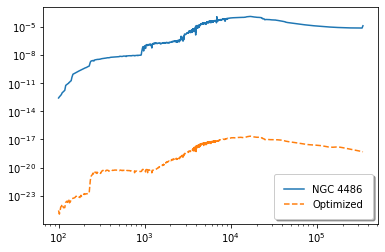

In [59]:
lb   = np.zeros(2)
ub   = np.full(2, 1e15)

starting_weight_array = np.zeros(2) + 0.01

print("Current Starting Position")
print(starting_weight_array)
print('Optimizing Guess ***********')

popt = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err)
print(popt)

ngc_4486_opt_guess2= galactic_model_guess(popt, ngc_4486_rest_wave)

plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label='NGC 4486')
plt.loglog(ngc_4486_rest_wave, ngc_4486_opt_guess2, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.show()

<ipython-input-26-bc449b0381d2>:342: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
<ipython-input-26-bc449b0381d2>:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

Steps Taken:  1000 Likelihood:  -1.1765379595399878e+40
Derived values are (weight array): 
 [7.18901093e+10 4.40047444e+10]


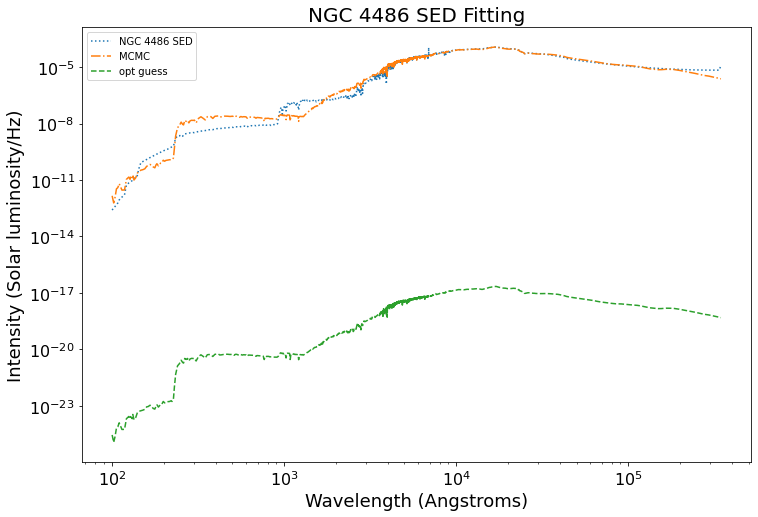

In [60]:
with Pool() as pool:
    perturbation = popt * 0.01
    no_of_Chain=500
    no_of_steps=1000

    text_label=[]

    for i in range(2):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(2)
    ub   = np.full(2, 1e12)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

    guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 5), args=(lb, ub, galactic_model_guess, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 1000
    convergence_accuracy = 1e-4
    convergence_check = False
    
    sampler2, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, ngc_4486_flux, ngc_4486_flux_err, ngc_4486_rest_wave, galactic_model_guess)

    title = "NGC 4486 SED Fitting"
    galaxy = "NGC 4486 SED"
    
    best_fit2, exp_weight_array2 = print_and_plot_results(sampler, ngc_4486_rest_wave, ngc_4486_flux, title, galaxy, galactic_model_guess)
    
    plt.loglog(ngc_4486_rest_wave, best_fit2, label = "MCMC", ls = '-.')
    plt.loglog(ngc_4486_rest_wave,ngc_4486_opt_guess2,label='opt guess', ls='--')
    plt.legend()
    plt.show()

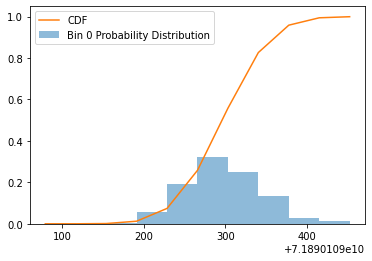

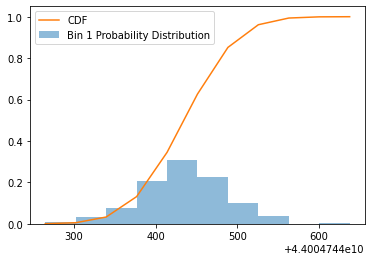

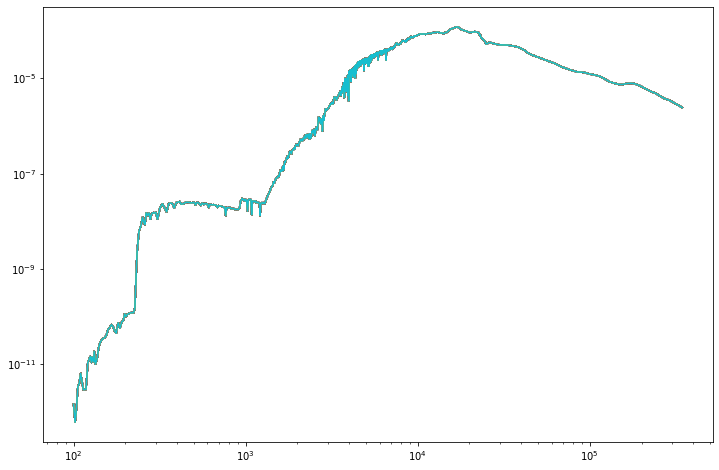

Derived Mass-to-light Ratio: 1.811e+00 +/- 3.962e-11
Input Mass-to-light Ratio: 6.300e+00
Standard Deviations Away: 113287191859.180


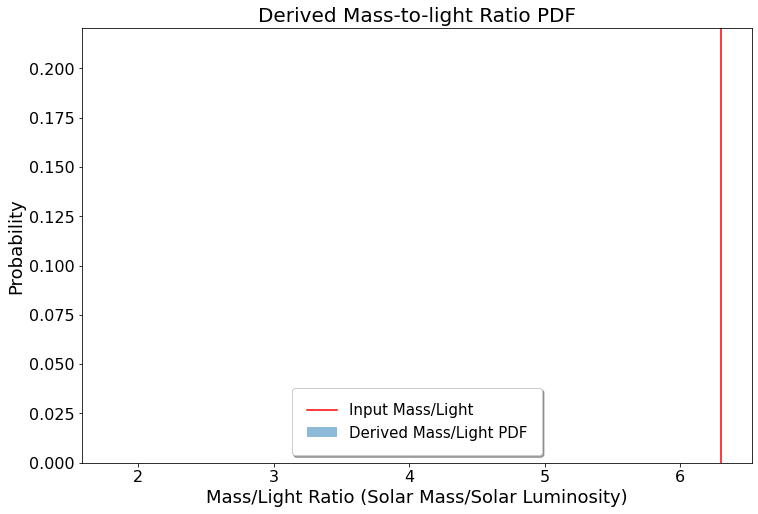

In [61]:
samples = 100
derived_mass_light, derived_mass_light_err = mass_light_pdf(sampler2, samples, ngc_4486_flux, ngc_4486_rest_wave)
input_mass_light = 6.3

print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
plt.axvline(x = input_mass_light, color = 'red', label = "Input Mass/Light")
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.show()

### 6 Parameters

In [62]:
metallicity_space = np.array([-1, 1])
age_space = np.array([10, 11, 13.24])

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01]
Optimizing Guess ***********
[0.01 0.01 0.01 0.01 0.01 0.01]


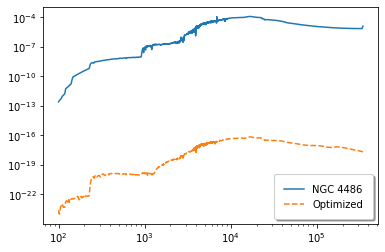

In [66]:
lb   = np.zeros(6)
ub   = np.full(6, 1e15)

starting_weight_array = np.zeros(6) + 0.01

print("Current Starting Position")
print(starting_weight_array)
print('Optimizing Guess ***********')

popt6 = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err)
print(popt6)

ngc_4486_opt_guess6= galactic_model_guess(popt6, ngc_4486_rest_wave)

plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label='NGC 4486')
plt.loglog(ngc_4486_rest_wave, ngc_4486_opt_guess6, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.show()

Steps Taken:  1000 Likelihood:  -1.1750716305098837e+40


<ipython-input-26-bc449b0381d2>:342: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
<ipython-input-26-bc449b0381d2>:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

Derived values are (weight array): 
 [7.35400262e-06 9.65935987e-06 7.16962268e+10 1.84344183e+09
 2.07534005e+09 3.98248279e+10]


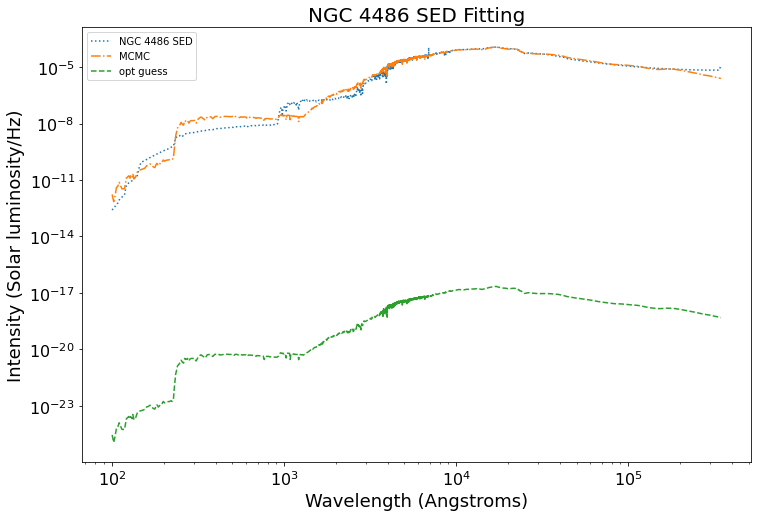

In [69]:
with Pool() as pool:
    perturbation = popt6 * 0.01
    no_of_Chain=500
    no_of_steps=1000

    text_label=[]

    for i in range(6):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(6)
    ub   = np.full(6, 1e12)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

    guesses = [popt6 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 5), args=(lb, ub, galactic_model_guess, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 1000
    convergence_accuracy = 1e-4
    convergence_check = False
    
    sampler6, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, ngc_4486_flux, ngc_4486_flux_err, ngc_4486_rest_wave, galactic_model_guess)

    title = "NGC 4486 SED Fitting"
    galaxy = "NGC 4486 SED"
    
    best_fit6, exp_weight_array6 = print_and_plot_results(sampler, ngc_4486_rest_wave, ngc_4486_flux, title, galaxy, galactic_model_guess)
    
    plt.loglog(ngc_4486_rest_wave, best_fit6, label = "MCMC", ls = '-.')
    plt.loglog(ngc_4486_rest_wave,ngc_4486_opt_guess6,label='opt guess', ls='--')
    plt.legend()
    plt.show()

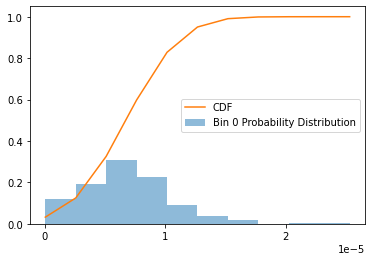

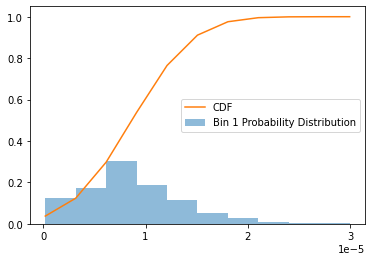

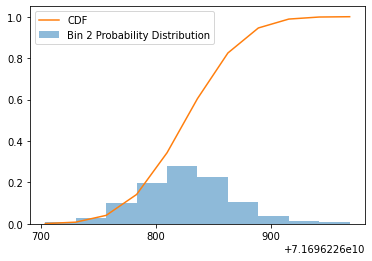

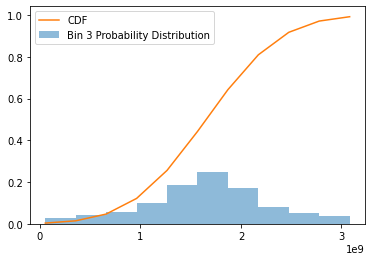

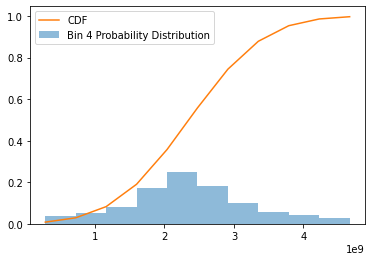

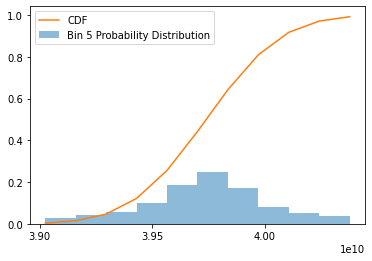

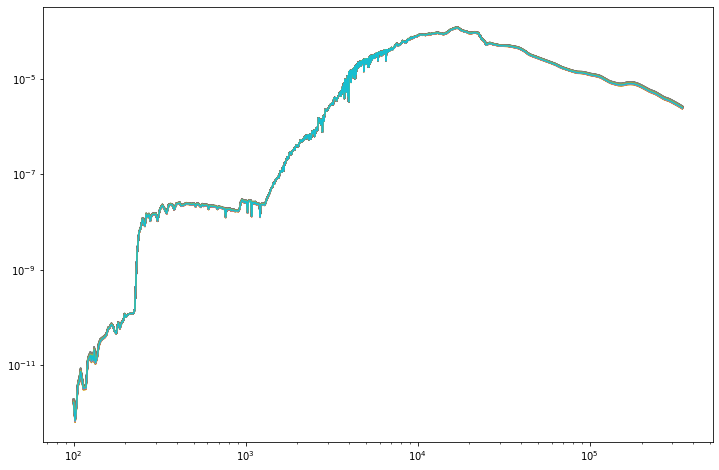

Derived Mass-to-light Ratio: 1.807e+00 +/- 5.011e-04
Input Mass-to-light Ratio: 6.300e+00
Standard Deviations Away: 8965.872


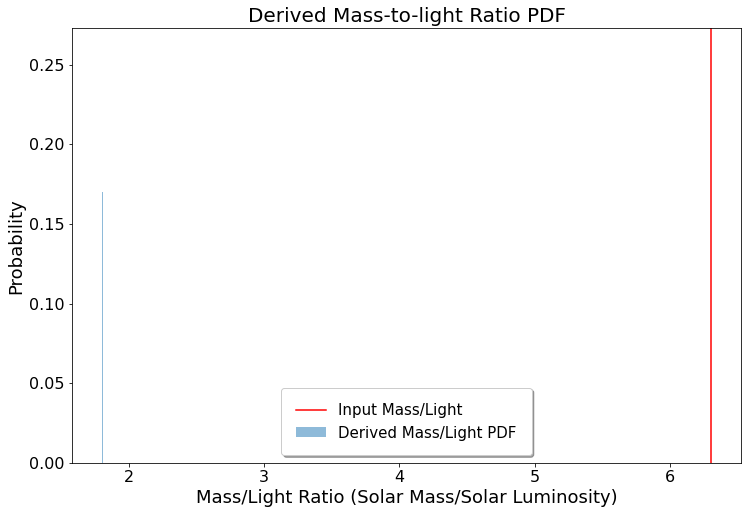

In [70]:
samples = 100
derived_mass_light, derived_mass_light_err = mass_light_pdf(sampler6, samples, ngc_4486_flux, ngc_4486_rest_wave)
input_mass_light = 6.3

print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
plt.axvline(x = input_mass_light, color = 'red', label = "Input Mass/Light")
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.show()

### 12 Parameters

In [80]:
metallicity_space = np.array([-3, 0, 1])
age_space = np.logspace(-3, 1.146, 4)

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Optimizing Guess ***********
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


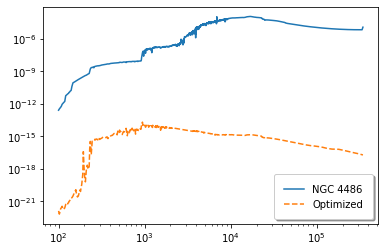

In [72]:
lb   = np.zeros(12)
ub   = np.full(12, 1e15)

starting_weight_array = np.zeros(12) + 0.01

print("Current Starting Position")
print(starting_weight_array)
print('Optimizing Guess ***********')

popt12 = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err)
print(popt12)

ngc_4486_opt_guess12= galactic_model_guess(popt12, ngc_4486_rest_wave)

plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label='NGC 4486')
plt.loglog(ngc_4486_rest_wave, ngc_4486_opt_guess12, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.show()

<ipython-input-26-bc449b0381d2>:342: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
<ipython-input-26-bc449b0381d2>:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

Steps Taken:  1000 Likelihood:  -8.250661153574492e+39
Derived values are (weight array): 
 [1.36567369e+05 4.70764878e+04 1.54083469e+05 1.89095890e+09
 2.62172246e+04 1.17192565e+04 2.30105842e+05 1.06442985e+11
 1.11248568e+04 6.38887021e+06 1.37183786e+09 8.87556804e+09]


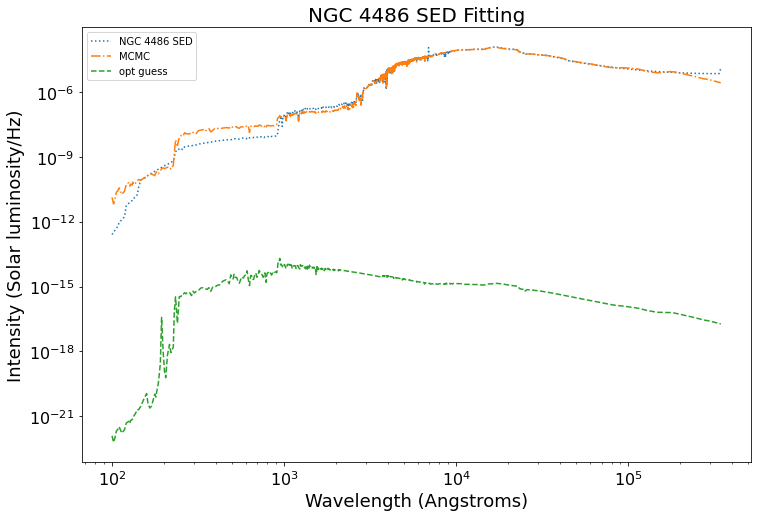

In [73]:
with Pool() as pool:
    perturbation = popt12 * 0.01
    no_of_Chain=500
    no_of_steps=1000

    text_label=[]

    for i in range(12):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(12)
    ub   = np.full(12, 1e12)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

    guesses = [popt12 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 5), args=(lb, ub, galactic_model_guess, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 1000
    convergence_accuracy = 1e-4
    convergence_check = False
    
    sampler12, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, ngc_4486_flux, ngc_4486_flux_err, ngc_4486_rest_wave, galactic_model_guess)

    title = "NGC 4486 SED Fitting"
    galaxy = "NGC 4486 SED"
    
    best_fit12, exp_weight_array12 = print_and_plot_results(sampler, ngc_4486_rest_wave, ngc_4486_flux, title, galaxy, galactic_model_guess)
    
    plt.loglog(ngc_4486_rest_wave, best_fit12, label = "MCMC", ls = '-.')
    plt.loglog(ngc_4486_rest_wave,ngc_4486_opt_guess12,label='opt guess', ls='--')
    plt.legend()
    plt.show()

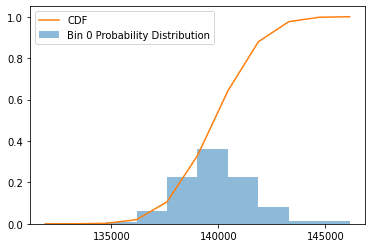

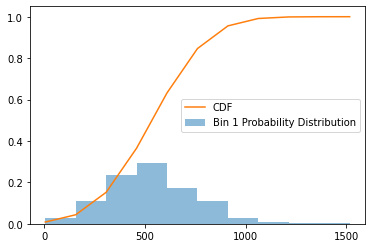

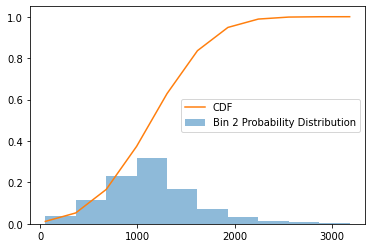

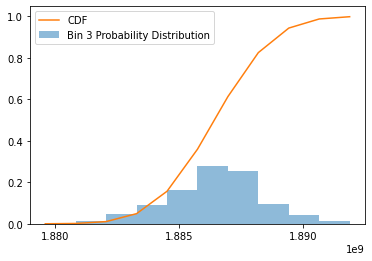

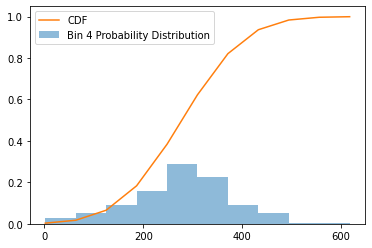

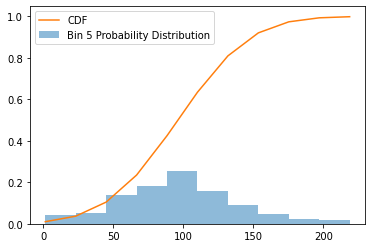

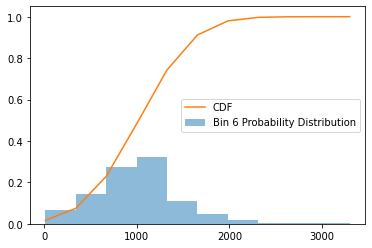

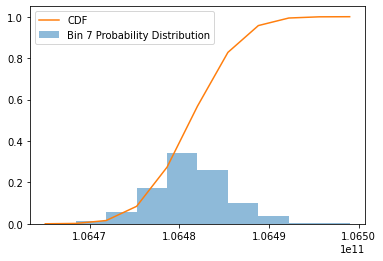

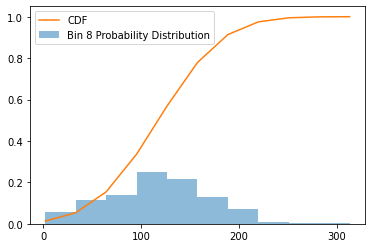

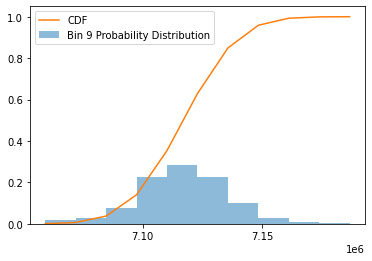

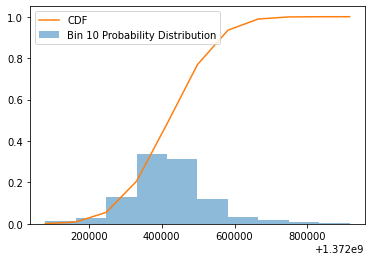

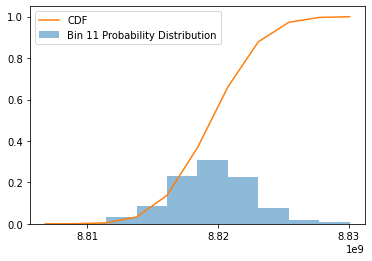

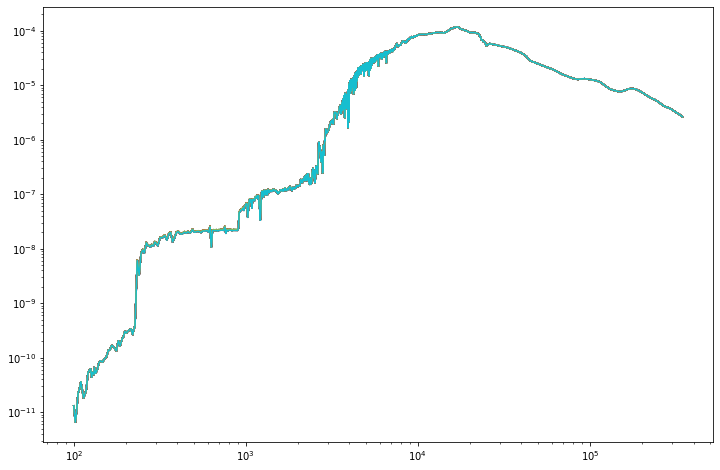

Derived Mass-to-light Ratio: 1.878e+00 +/- 9.112e-05
Input Mass-to-light Ratio: 6.300e+00
Standard Deviations Away: 48535.136


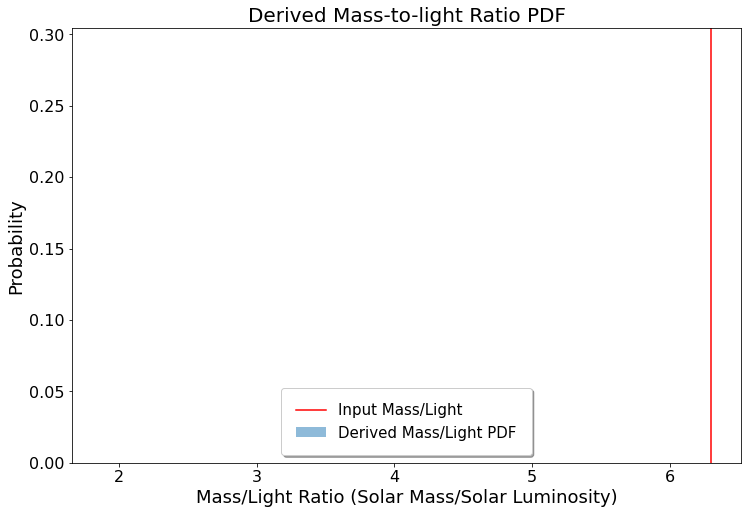

In [74]:
samples = 100
derived_mass_light, derived_mass_light_err = mass_light_pdf(sampler12, samples, ngc_4486_flux, ngc_4486_rest_wave)
input_mass_light = 6.3

print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
plt.axvline(x = input_mass_light, color = 'red', label = "Input Mass/Light")
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.show()

### 15 Parameters

In [120]:
metallicity_space = np.array([-3, 0, 1])
age_space = np.linspace(0.001, 14, 5)

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01]
Optimizing Guess ***********
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01]


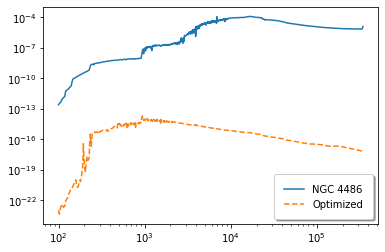

In [121]:
lb   = np.zeros(15)
ub   = np.full(15, 1e15)

starting_weight_array = np.zeros(15) + 0.01

print("Current Starting Position")
print(starting_weight_array)
print('Optimizing Guess ***********')

popt15 = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err)
print(popt15)

ngc_4486_opt_guess15= galactic_model_guess(popt15, ngc_4486_rest_wave)

plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label='NGC 4486')
plt.loglog(ngc_4486_rest_wave, ngc_4486_opt_guess15, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.show()

<ipython-input-26-bc449b0381d2>:342: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Steps Taken:  1000 Likelihood:  -9.05789928033351e+39
Derived values are (weight array): 
 [1.52676894e+06 2.16231384e+08 4.79857183e+08 1.14157301e+09
 2.95974133e+09 5.53650348e+05 9.14093039e+08 6.49990544e+09
 5.75408828e+09 7.49103042e+10 8.73144749e+05 1.34997480e+09
 6.44895923e+09 4.57531116e+09 4.97199863e+09]


<ipython-input-26-bc449b0381d2>:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


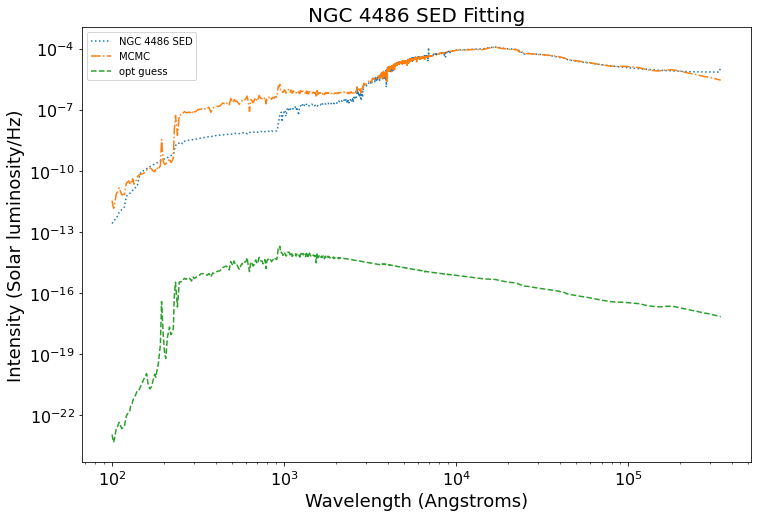

In [122]:
with Pool() as pool:
    perturbation = popt15 * 0.01
    no_of_Chain=500
    no_of_steps=1000

    text_label=[]

    for i in range(15):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(15)
    ub   = np.full(15, 1e12)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

    guesses = [popt15 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 5), args=(lb, ub, galactic_model_guess, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 1000
    convergence_accuracy = 1e-4
    convergence_check = False
    
    sampler15, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, ngc_4486_flux, ngc_4486_flux_err, ngc_4486_rest_wave, galactic_model_guess)

    title = "NGC 4486 SED Fitting"
    galaxy = "NGC 4486 SED"
    
    best_fit15, exp_weight_array15 = print_and_plot_results(sampler15, ngc_4486_rest_wave, ngc_4486_flux, title, galaxy, galactic_model_guess)
    
    plt.loglog(ngc_4486_rest_wave, best_fit15, label = "MCMC", ls = '-.')
    plt.loglog(ngc_4486_rest_wave,ngc_4486_opt_guess15,label='opt guess', ls='--')
    plt.legend()
    plt.show()

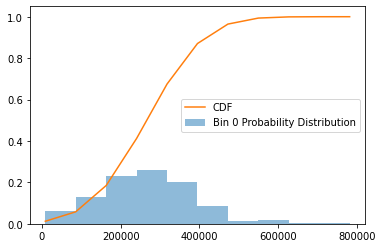

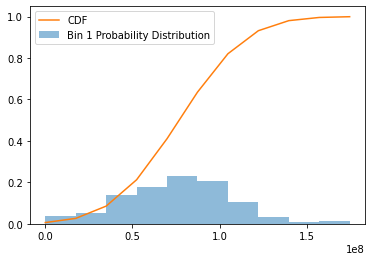

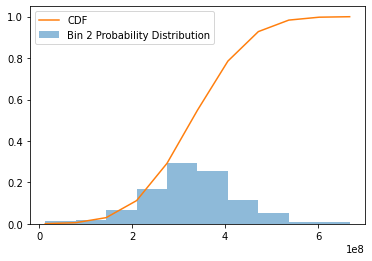

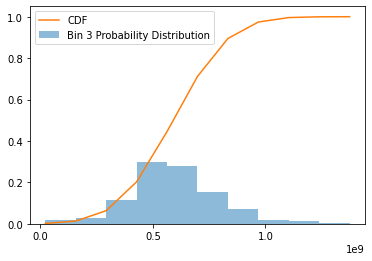

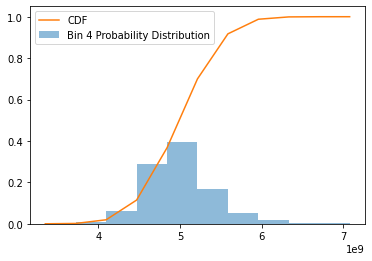

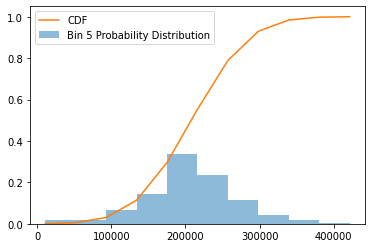

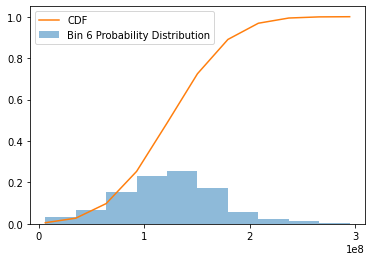

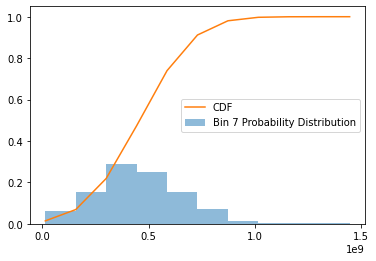

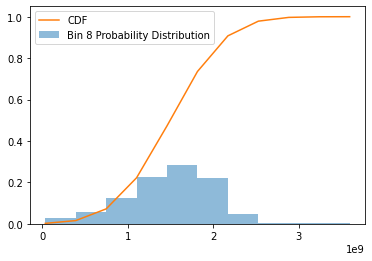

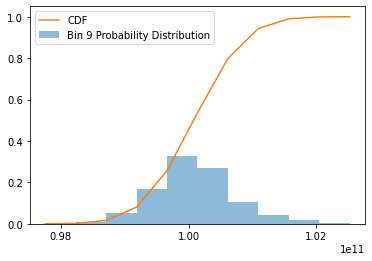

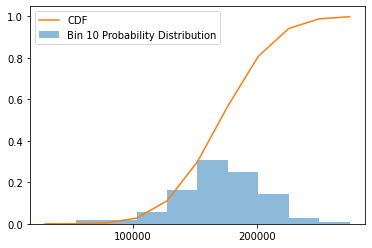

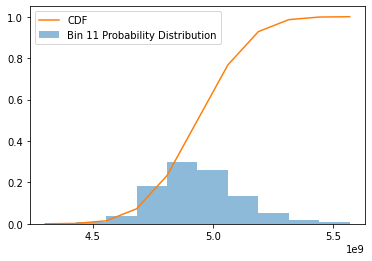

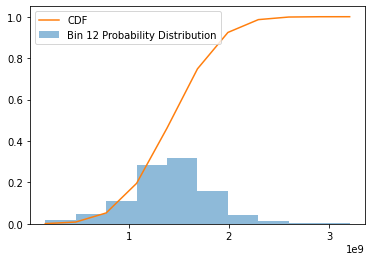

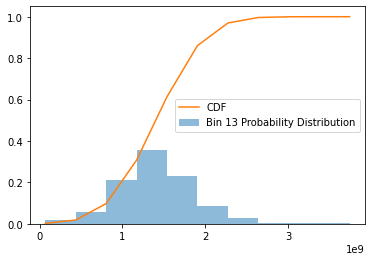

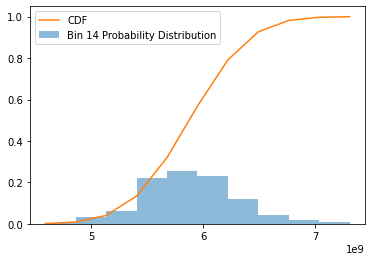

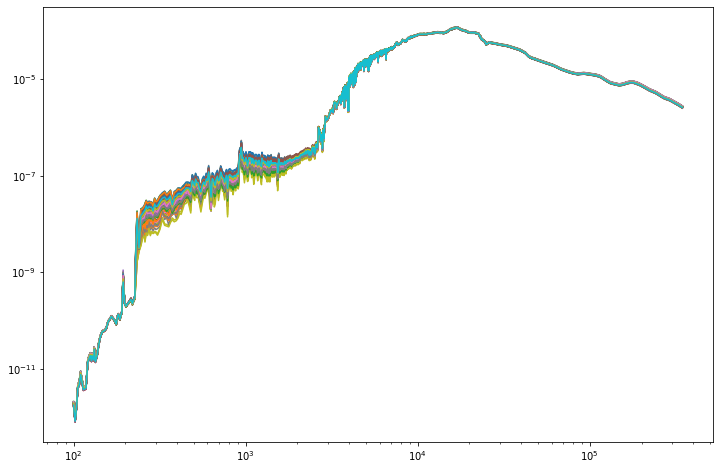

Derived Mass-to-light Ratio: 1.911e+00 +/- 9.138e-03
Input Mass-to-light Ratio: 6.300e+00
Standard Deviations Away: 480.313


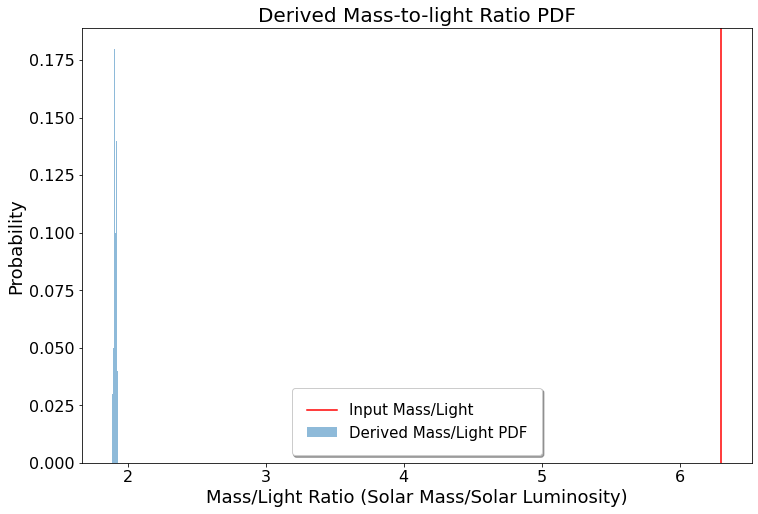

In [123]:
samples = 100
derived_mass_light, derived_mass_light_err = mass_light_pdf(sampler15, samples, ngc_4486_flux, ngc_4486_rest_wave)
input_mass_light = 6.3

print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
plt.axvline(x = input_mass_light, color = 'red', label = "Input Mass/Light")
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.show()

### 21 Parameters

In [125]:
metallicity_space = np.array([-3, 0, 1])
age_space = np.linspace(0.001, 14, 7)

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Optimizing Guess ***********
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


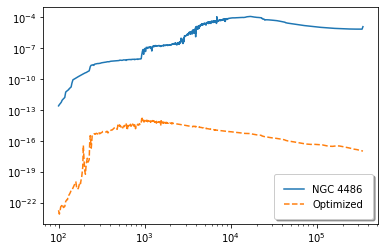

In [118]:
lb   = np.zeros(21)
ub   = np.full(21, 1e15)

starting_weight_array = np.zeros(21) + 0.01

print("Current Starting Position")
print(starting_weight_array)
print('Optimizing Guess ***********')

popt21 = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err)
print(popt21)

ngc_4486_opt_guess21= galactic_model_guess(popt21, ngc_4486_rest_wave)

plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label='NGC 4486')
plt.loglog(ngc_4486_rest_wave, ngc_4486_opt_guess21, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.show()

<ipython-input-26-bc449b0381d2>:342: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Steps Taken:  1000 Likelihood:  -1.2043640301487719e+40


<ipython-input-26-bc449b0381d2>:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Derived values are (weight array): 
 [4.09653083e+05 3.73182243e+07 7.23969665e+07 2.27195444e+08
 8.94912347e+07 9.28453078e+07 1.47298704e+10 1.76836042e+06
 2.42090078e+08 8.67208763e+08 2.20455891e+10 2.46479808e+09
 1.10952973e+10 1.04398018e+10 4.48351561e+05 1.36020446e+08
 1.73814832e+09 6.52380811e+09 3.24051826e+09 1.73701391e+10
 2.74139011e+09]


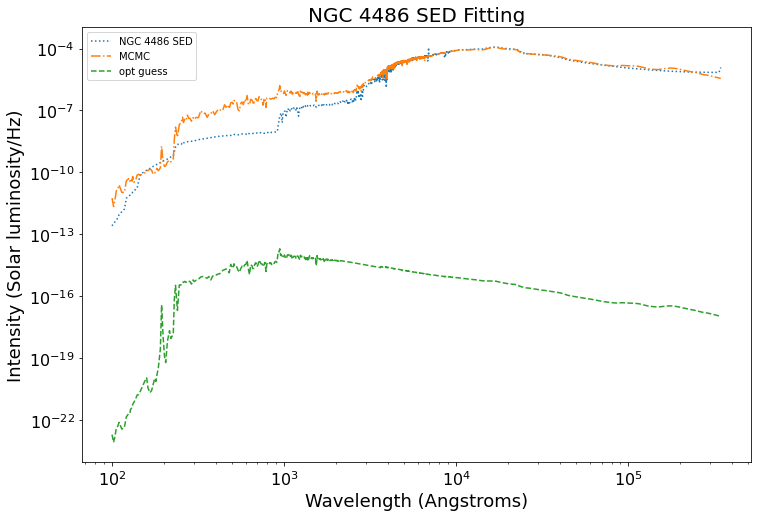

In [119]:
with Pool() as pool:
    perturbation = popt21 * 0.01
    no_of_Chain=500
    no_of_steps=1000

    text_label=[]

    for i in range(21):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(21)
    ub   = np.full(21, 1e12)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

    guesses = [popt21 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 5), args=(lb, ub, galactic_model_guess, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 1000
    convergence_accuracy = 1e-4
    convergence_check = False
    
    sampler21, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, ngc_4486_flux, ngc_4486_flux_err, ngc_4486_rest_wave, galactic_model_guess)

    title = "NGC 4486 SED Fitting"
    galaxy = "NGC 4486 SED"
    
    best_fit21, exp_weight_array21 = print_and_plot_results(sampler, ngc_4486_rest_wave, ngc_4486_flux, title, galaxy, galactic_model_guess)
    
    plt.loglog(ngc_4486_rest_wave, best_fit21, label = "MCMC", ls = '-.')
    plt.loglog(ngc_4486_rest_wave,ngc_4486_opt_guess21,label='opt guess', ls='--')
    plt.legend()
    plt.show()

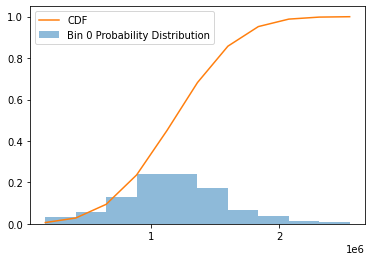

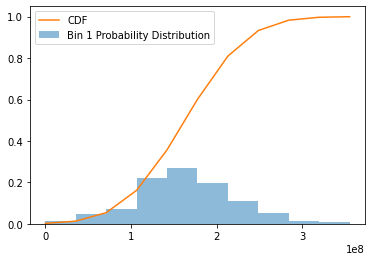

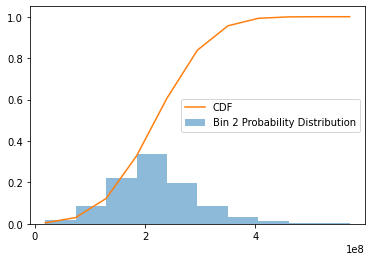

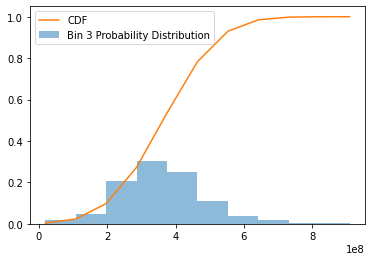

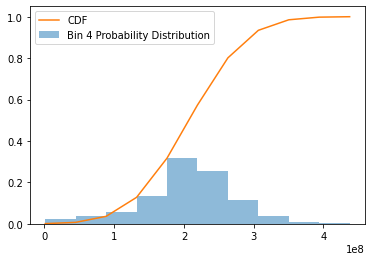

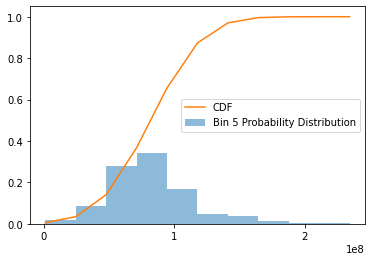

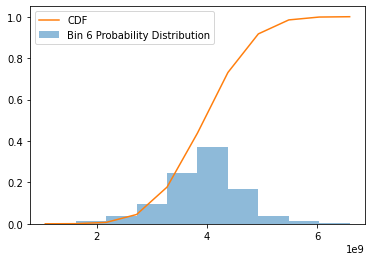

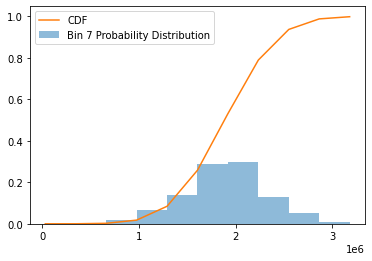

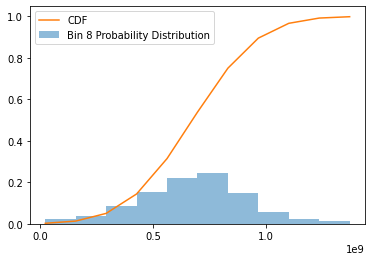

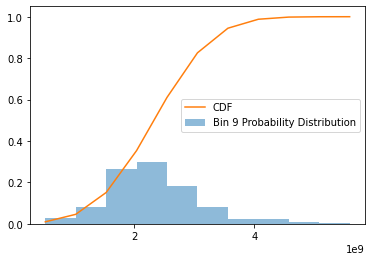

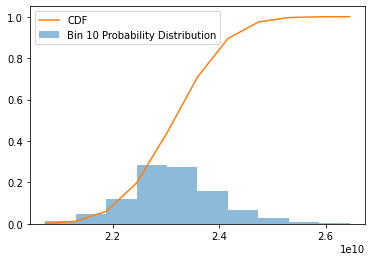

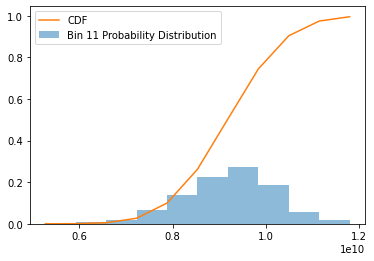

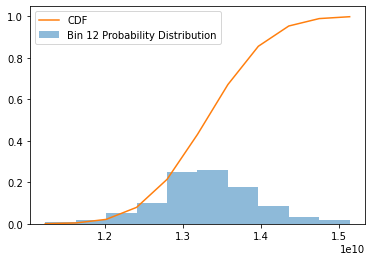

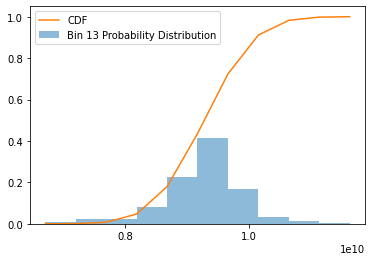

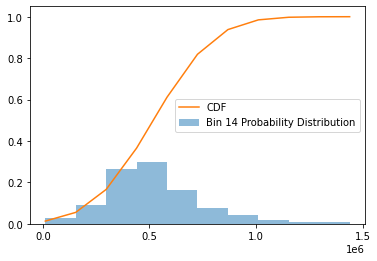

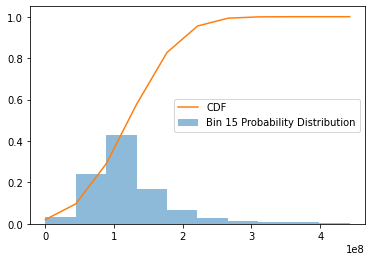

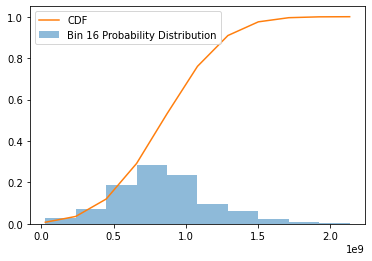

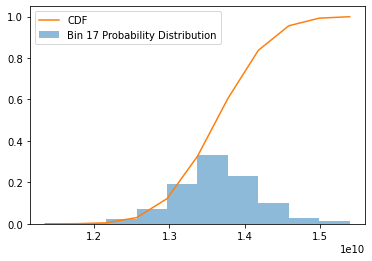

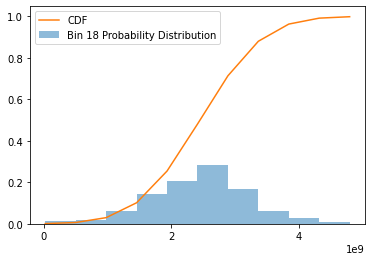

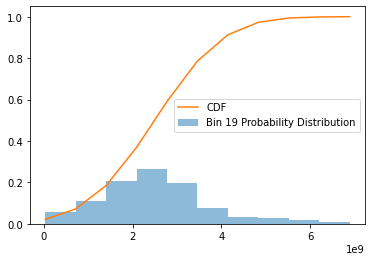

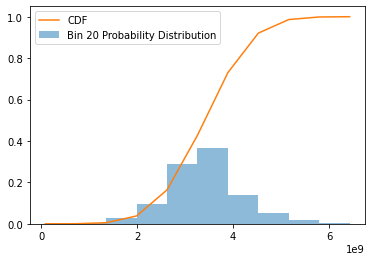

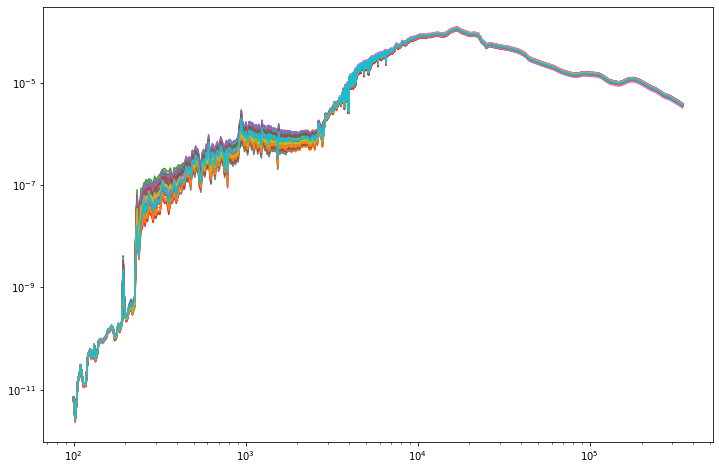

Derived Mass-to-light Ratio: 1.283e+00 +/- 2.740e-02
Input Mass-to-light Ratio: 6.300e+00
Standard Deviations Away: 183.146


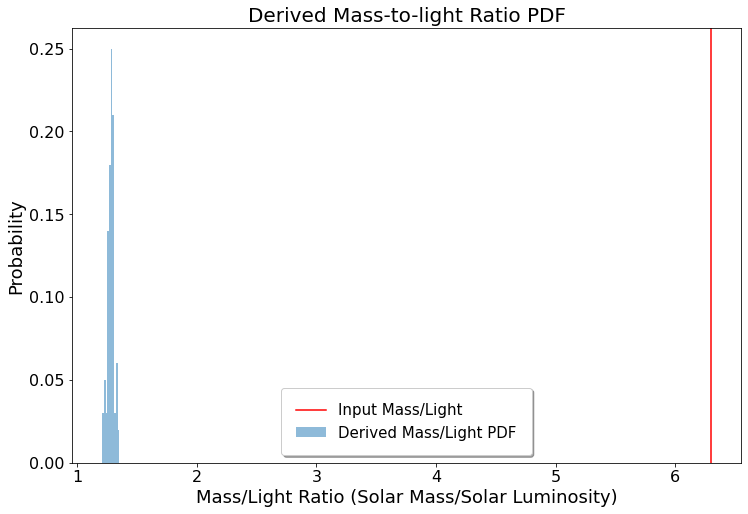

In [126]:
samples = 100
derived_mass_light, derived_mass_light_err = mass_light_pdf(sampler21, samples, ngc_4486_flux, ngc_4486_rest_wave)
input_mass_light = 6.3

print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
plt.axvline(x = input_mass_light, color = 'red', label = "Input Mass/Light")
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.show()

### 30 Parameter- Linear Age Space

In [140]:
metallicity_space = np.array([-3, 0, 1])
age_space = np.linspace(0.001, 14, 10)

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
Optimizing Guess ***********
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]


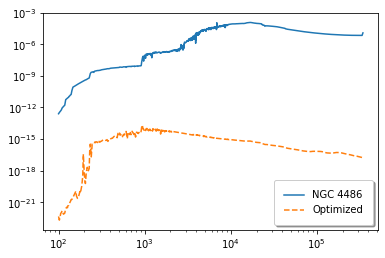

In [141]:
lb   = np.zeros(30)
ub   = np.full(30, 1e15)

starting_weight_array = np.zeros(30) + 0.01

print("Current Starting Position")
print(starting_weight_array)
print('Optimizing Guess ***********')

popt30 = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err)
print(popt30)

ngc_4486_opt_guess30 = galactic_model_guess(popt30, ngc_4486_rest_wave)

plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label='NGC 4486')
plt.loglog(ngc_4486_rest_wave, ngc_4486_opt_guess30, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.show()

<ipython-input-26-bc449b0381d2>:342: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Steps Taken:  1000 Likelihood:  -2.529000829932657e+40


<ipython-input-26-bc449b0381d2>:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Derived values are (weight array): 
 [4.44167734e+06 9.78676569e+07 5.25675413e+07 3.85432323e+09
 2.69969832e+08 1.48528345e+09 1.84431637e+08 7.40688215e+07
 6.41546154e+08 1.32974858e+08 9.88262593e+05 1.03268276e+09
 7.13050248e+08 5.09580836e+09 9.93421447e+09 8.74355962e+09
 2.88341490e+09 2.97306569e+08 1.20012359e+08 8.51622157e+09
 8.97778981e+05 3.21866674e+09 1.03856000e+08 1.77604735e+09
 9.74716086e+09 1.13980794e+09 7.71218415e+09 2.54700675e+09
 1.96731721e+09 3.97643906e+09]


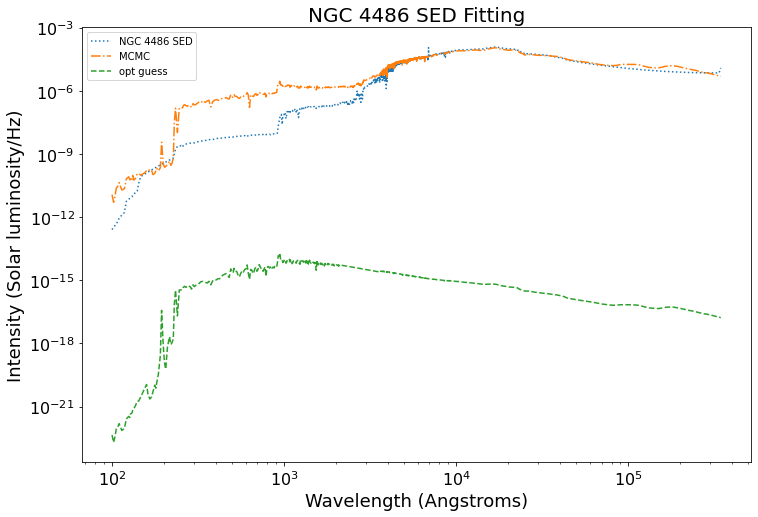

In [142]:
with Pool() as pool:
    perturbation = popt30 * 0.01
    no_of_Chain=500
    no_of_steps=1000

    text_label=[]

    for i in range(30):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(30)
    ub   = np.full(30, 1e12)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.
    
    
    filename = "ngc_4486.h5"
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)
    
    guesses = [popt30 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 5), args=(lb, ub, galactic_model_guess, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err), backend = backend)
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 1000
    convergence_accuracy = 1e-4
    convergence_check = False
    
    sampler30, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, ngc_4486_flux, ngc_4486_flux_err, ngc_4486_rest_wave, galactic_model_guess)

    title = "NGC 4486 SED Fitting"
    galaxy = "NGC 4486 SED"
    
    best_fit30, exp_weight_array30 = print_and_plot_results(sampler, ngc_4486_rest_wave, ngc_4486_flux, title, galaxy, galactic_model_guess)
    
    plt.loglog(ngc_4486_rest_wave, best_fit30, label = "MCMC", ls = '-.')
    plt.loglog(ngc_4486_rest_wave,ngc_4486_opt_guess30,label='opt guess', ls='--')
    plt.legend()
    plt.show()

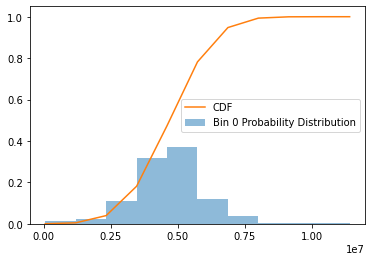

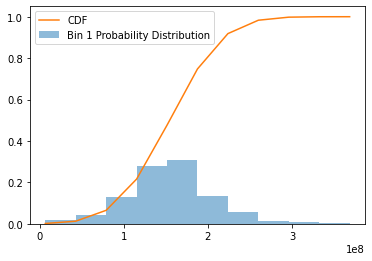

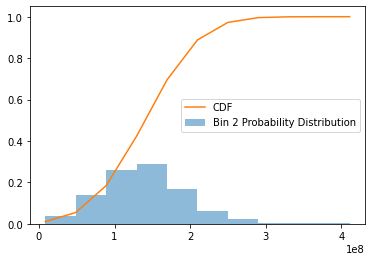

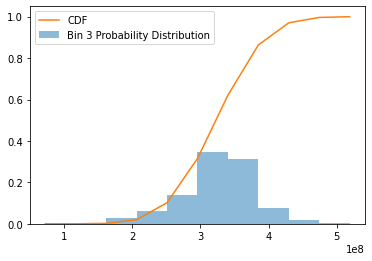

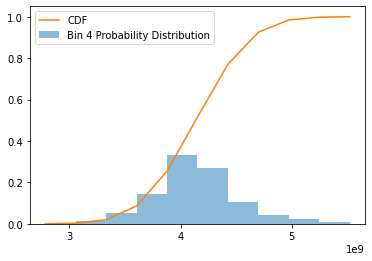

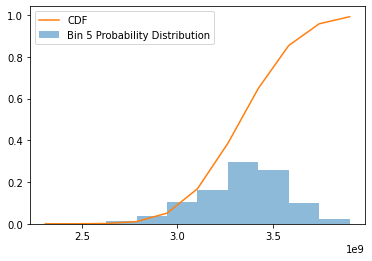

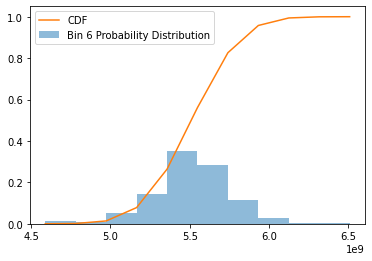

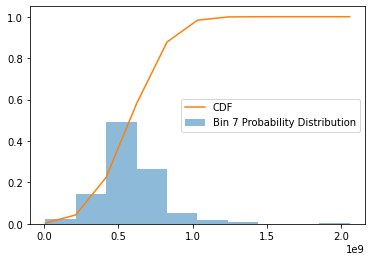

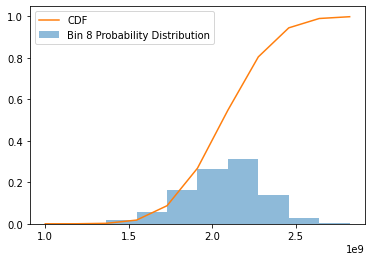

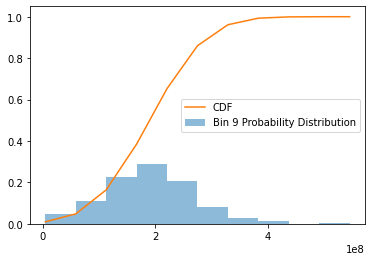

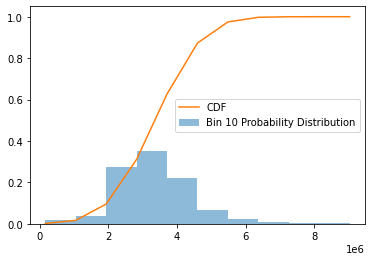

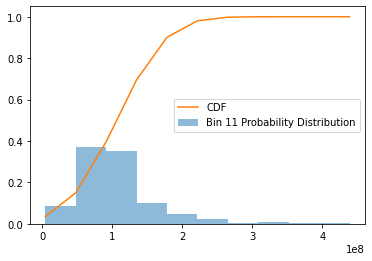

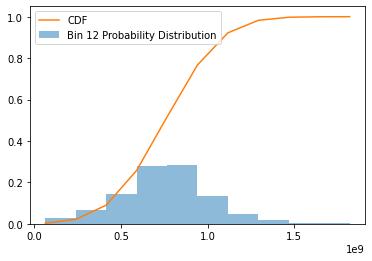

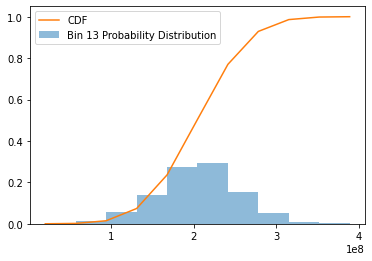

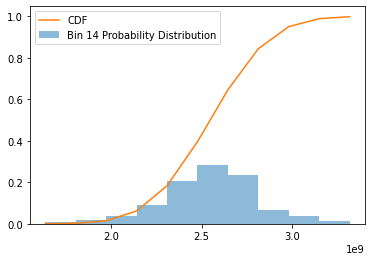

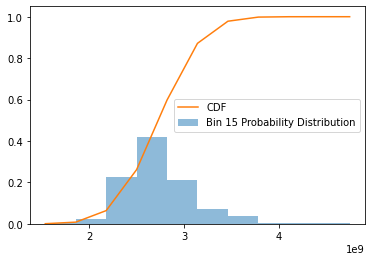

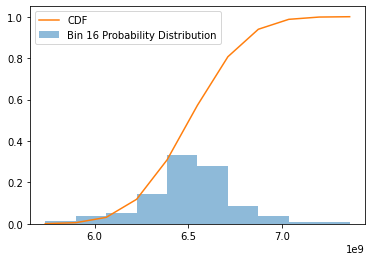

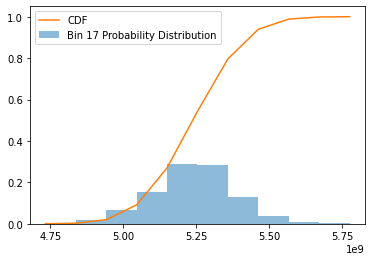

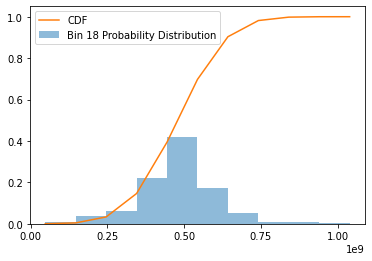

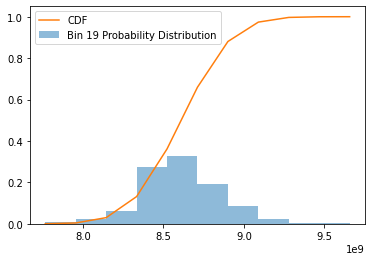

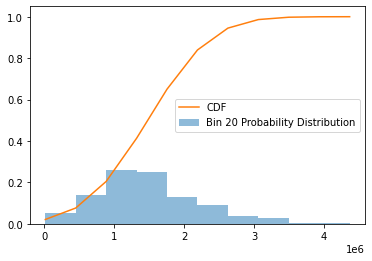

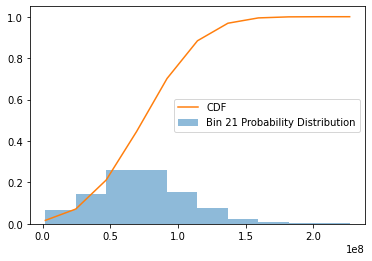

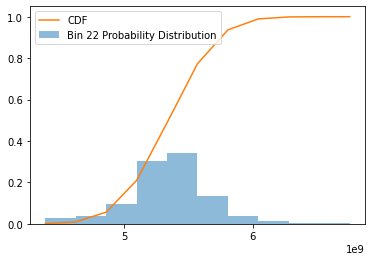

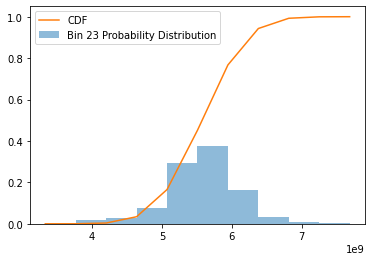

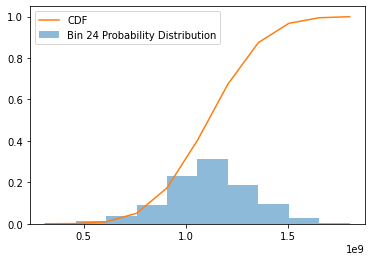

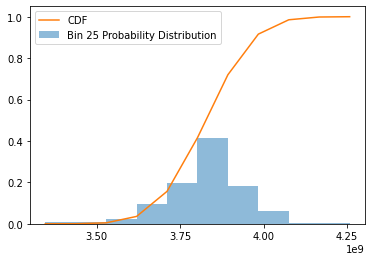

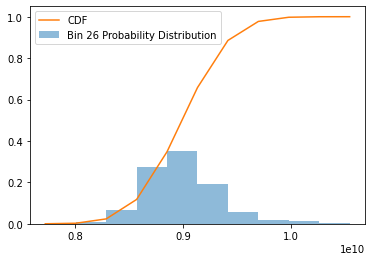

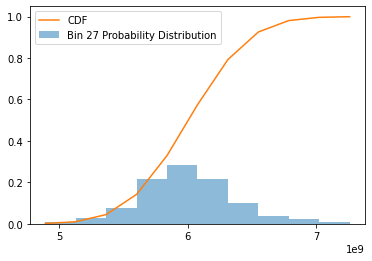

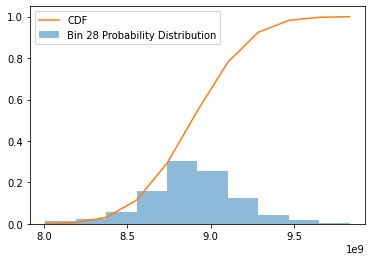

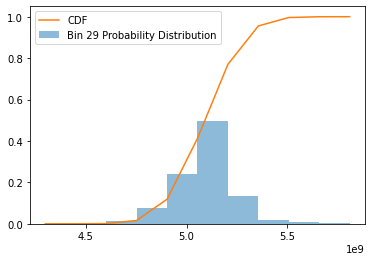

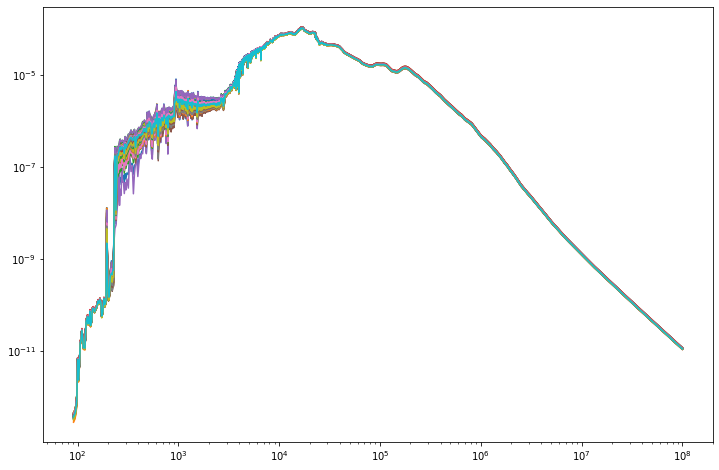

Derived Mass-to-light Ratio: 1.153e+00 +/- 5.208e-02
Input Mass-to-light Ratio: 6.300e+00
Standard Deviations Away: 98.841


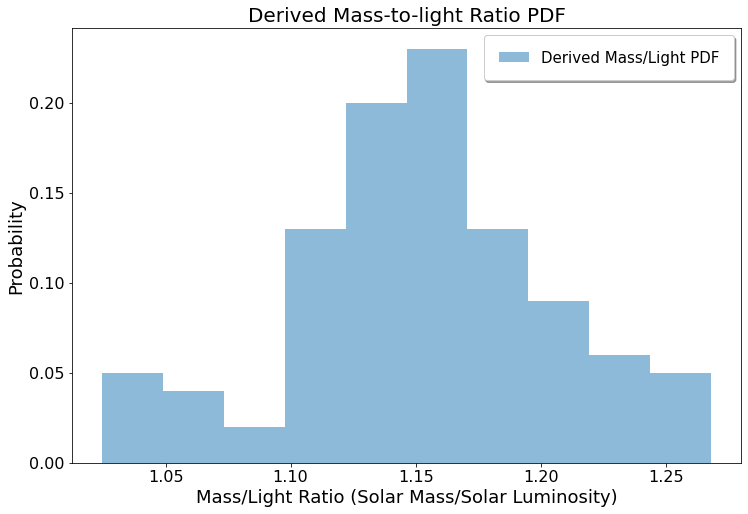

In [130]:
samples = 100
derived_mass_light, derived_mass_light_err = mass_light_pdf(sampler30, samples, ngc_4486_flux, wave)
input_mass_light = 6.3
print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
#plt.axvline(x = input_mass_light, color = 'red', label = "Input Mass/Light")
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.savefig("mass_light_pdf_ngc_4486.jpg")    
plt.show()

### 30 Parameters - Log Age Space

In [135]:
metallicity_space = np.array([-3, 0, 1])
age_space = np.logspace(-3, 1.146, 10)

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
Optimizing Guess ***********
[0.2625 0.2625 0.01   0.2625 0.2625 0.2625 0.01   0.01   0.01   0.01
 0.2625 0.2625 0.2625 0.2625 0.2625 0.2625 0.01   0.01   0.01   0.01
 0.2625 0.2625 0.2625 0.2625 0.2625 0.01   0.01   0.01   0.01   0.01  ]


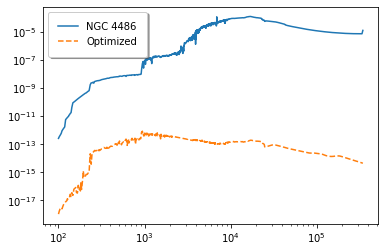

In [136]:
lb   = np.zeros(30)
ub   = np.full(30, 1e15)

starting_weight_array = np.zeros(30) + 0.01

print("Current Starting Position")
print(starting_weight_array)
print('Optimizing Guess ***********')

popt30_log = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err)
print(popt30_log)

ngc_4486_opt_guess30_log = galactic_model_guess(popt30_log, ngc_4486_rest_wave)

plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label='NGC 4486')
plt.loglog(ngc_4486_rest_wave, ngc_4486_opt_guess30_log, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.show()

<ipython-input-26-bc449b0381d2>:342: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Steps Taken:  1000 Likelihood:  -5.94830992202769e+41


<ipython-input-26-bc449b0381d2>:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Derived values are (weight array): 
 [1.29800227e+08 5.05950085e+06 2.18186270e+06 2.01947048e+06
 2.52764536e+08 1.35261079e+08 4.67012716e+06 3.99210994e+06
 1.20984108e+06 4.38810890e+05 2.60032837e+06 2.62029902e+06
 6.85751128e+07 1.16104182e+07 2.46498596e+07 1.47053263e+08
 3.77952135e+06 1.12298901e+06 2.36220403e+06 5.04622893e+05
 3.58053955e+06 3.97750535e+06 1.23979823e+08 3.46222111e+08
 1.85851071e+07 3.63429970e+05 4.33696669e+05 1.03526242e+06
 3.87216341e+05 1.10759489e+07]


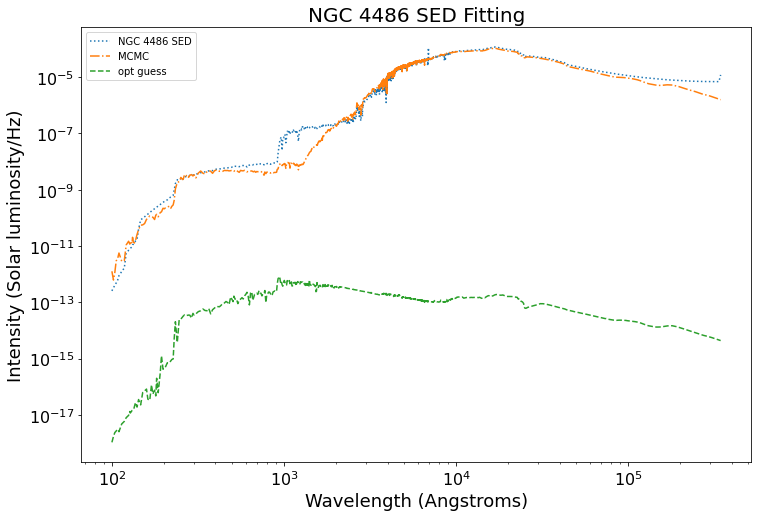

In [137]:
with Pool() as pool:
    perturbation = popt30_log * 0.01
    no_of_Chain=500
    no_of_steps=1000

    text_label=[]

    for i in range(30):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(30)
    ub   = np.full(30, 1e12)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.
    
    
    filename = "ngc_4486.h5"
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)
    
    guesses = [popt30_log + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 5), args=(lb, ub, galactic_model_guess, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err), backend = backend)
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 1000
    convergence_accuracy = 1e-4
    convergence_check = False
    
    sampler30_log, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, ngc_4486_flux, ngc_4486_flux_err, ngc_4486_rest_wave, galactic_model_guess)

    title = "NGC 4486 SED Fitting"
    galaxy = "NGC 4486 SED"
    
    best_fit30_log, exp_weight_array30_log = print_and_plot_results(sampler, ngc_4486_rest_wave, ngc_4486_flux, title, galaxy, galactic_model_guess)
    
    plt.loglog(ngc_4486_rest_wave, best_fit30_log, label = "MCMC", ls = '-.')
    plt.loglog(ngc_4486_rest_wave,ngc_4486_opt_guess30_log,label='opt guess', ls='--')
    plt.legend()
    plt.show()

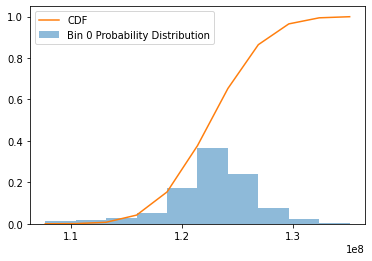

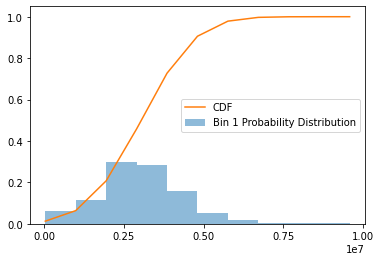

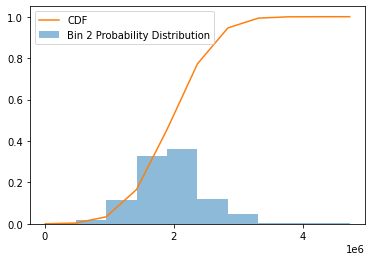

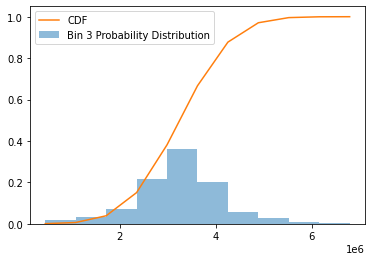

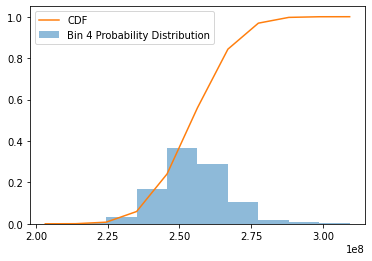

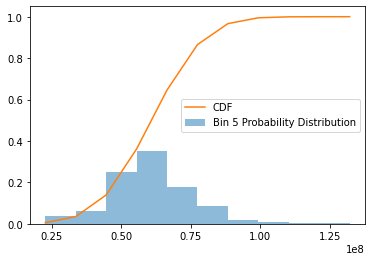

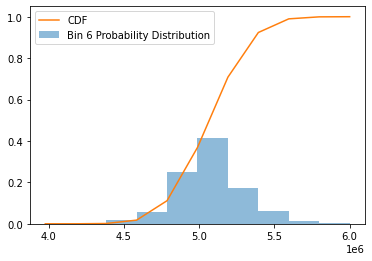

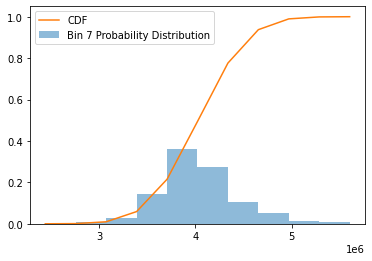

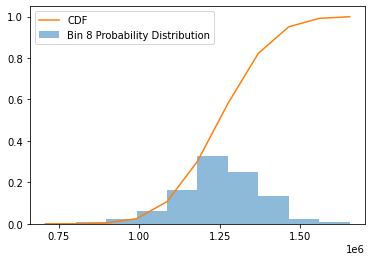

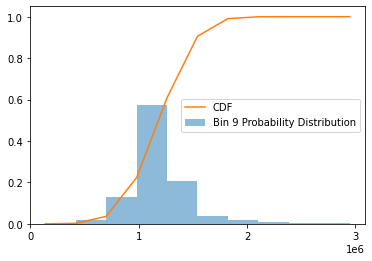

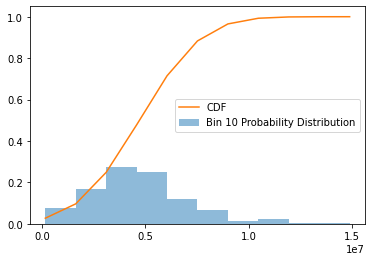

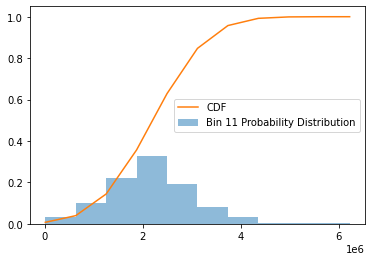

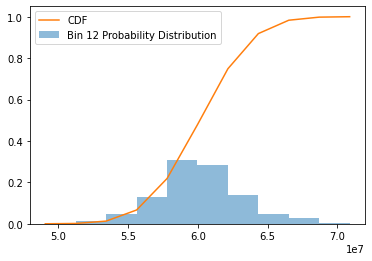

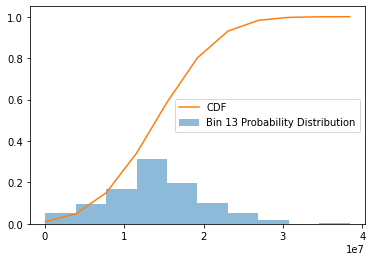

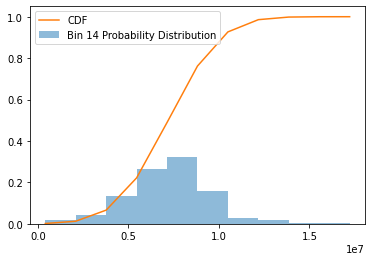

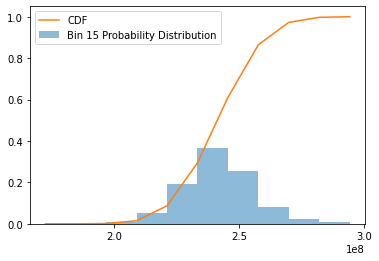

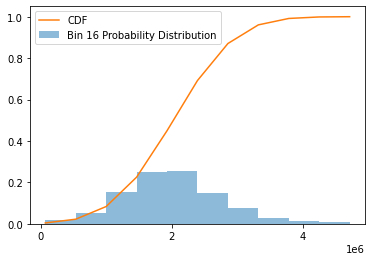

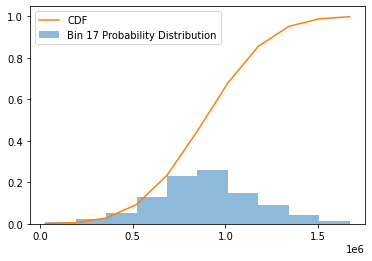

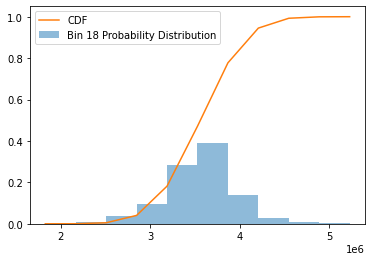

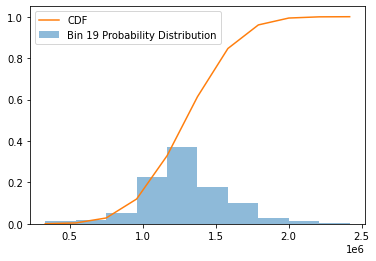

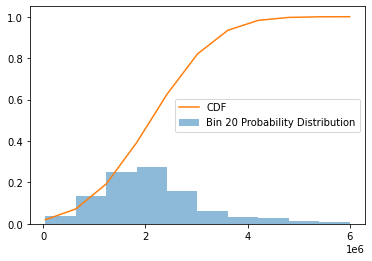

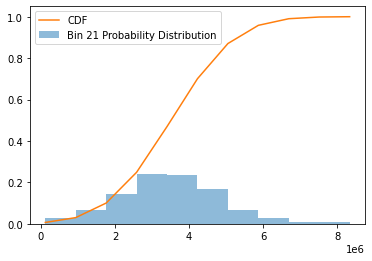

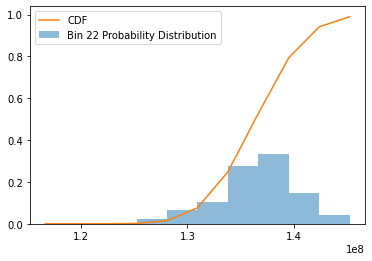

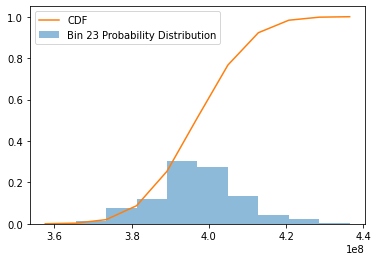

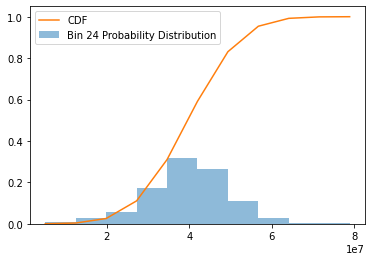

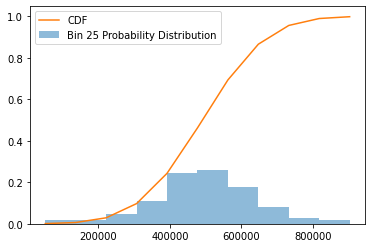

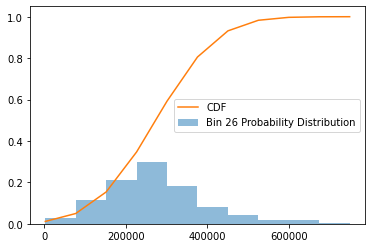

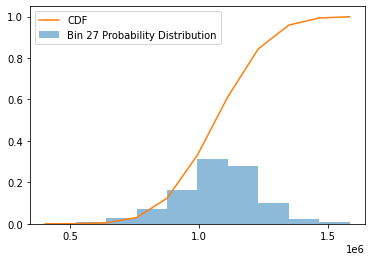

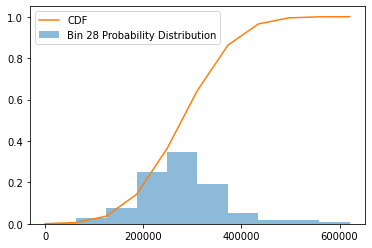

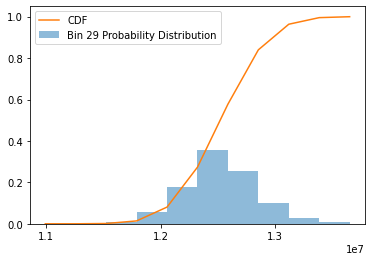

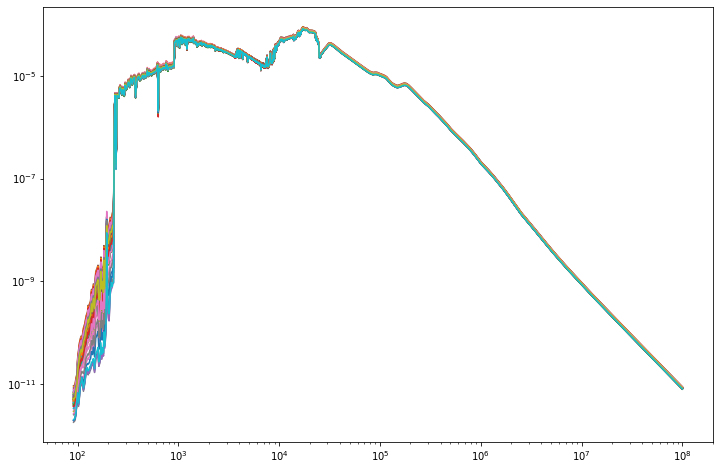

Derived Mass-to-light Ratio: 5.432e-03 +/- 1.659e-04
Input Mass-to-light Ratio: 6.300e+00
Standard Deviations Away: 37952.956


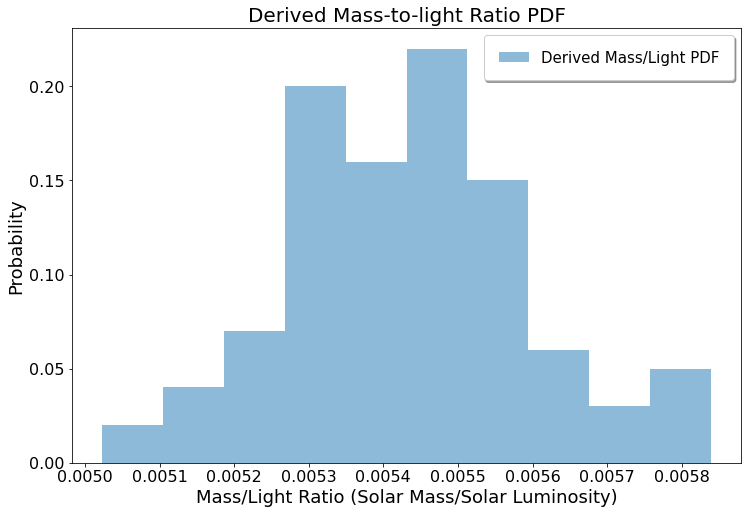

In [138]:
samples = 100
derived_mass_light, derived_mass_light_err = mass_light_pdf(sampler30, samples, ngc_4486_flux, wave)
input_mass_light = 6.3
print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
#plt.axvline(x = input_mass_light, color = 'red', label = "Input Mass/Light")
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.savefig("mass_light_pdf_ngc_4486.jpg")    
plt.show()

In [7]:
ndim = 30
nwalkers = 500
filename = "ngc_4486.h5"
new_backend = emcee.backends.HDFBackend(filename)
test_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, backend=new_backend)

M/L with Linear Age Space:  1.0812242085402914
M/L with Log Age Space:  0.0039021264139752062
Mass with Linear Age Space: 7.632e+10
Mass with Log Age Space: 1.31e+09


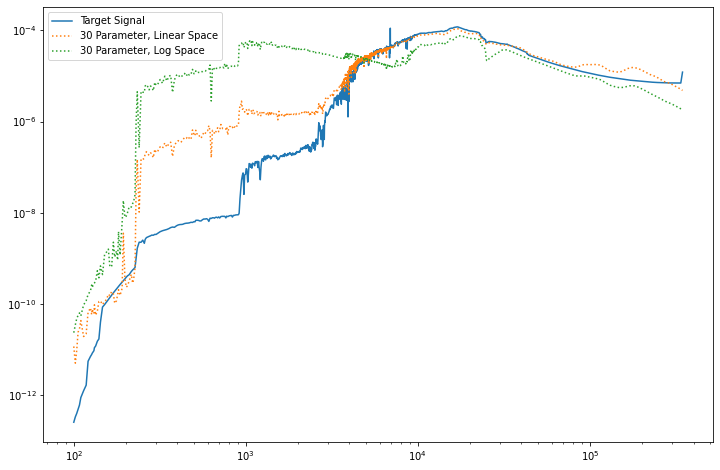

In [146]:
print("M/L with Linear Age Space: ", mass_to_light_calc(exp_weight_array30, best_fit30, ngc_4486_rest_wave))
print("M/L with Log Age Space: ", mass_to_light_calc(exp_weight_array30_log, best_fit30_log, ngc_4486_rest_wave))
print("Mass with Linear Age Space: {:.3e}".format(sum(exp_weight_array30)))
print("Mass with Log Age Space: {:.3}".format(sum(exp_weight_array30_log)))
fig = plt.figure(figsize = (12,8))
plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label = "Target Signal")
plt.loglog(ngc_4486_rest_wave, best_fit30, label = "30 Parameter, Linear Space", ls = ":")
plt.loglog(ngc_4486_rest_wave, best_fit30_log, label = "30 Parameter, Log Space", ls = ":")
plt.legend()
plt.show()